## **A basic model building and hyperparameter tuning has been developed using OneHot Encoding technique with Exploratory Data Analysis and local validation set for Feature Engineering of given data set**

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import os
PATH = os.getcwd()
PATH = os.path.join(PATH, 'drive', 'My Drive', 'Final_Hackathon')
PATH

'/content/drive/My Drive/Final_Hackathon'

# **Problem Statement : Broadband Outage Detection**

### **Problem Description:**

   India is seeing an explosion of new competitors in the Broadband space. 'India Broadband' is a company that is now seeing a lot of customer churn due to customer dissatisfaction because of broadband outages.
   
   A single Broadband outage could cause serious impact such as companies are unable to work, students are unable to do their assignments and even the finance of a country could be dropped down. As a result, knowing the reasons why an Broadband outage happens is desirable.

   The company has now curated a dataset, where it tracks several variables that it believes impact the `outage_duration`. They have tracked three different outage durations, `0` for no outage, `1` for short outages that last anywhere between a few minutes and a maximum of 2 hours, and `2` for long outages that can last from 2 hours to sometimes even a couple of days.

   You will now have to use these metrics that the company has tracked to create a machine learning model that will be able to predict the `outage_duration` so that the company can better handle outages and improve customer satisfaction and therefore reduce customer churn.

## **Data**

### **Attributes Description:**

* **ID:** ID is the instance where the event was recorded when there was an outage in the broadband connectivity in an area.
* **Area Code:** area_code is a categorical column, in which each unique value refers to an area where the `outage_duration` has been measured
* **Broadband Type:** broadband_type is the technology that the ISP uses for delivering broadband internet connection, there can be multiple types of broadband connections in a single area
* **Outage Type:** outage_type signifies the `5` different types of outages as classified by the engineering experts who remotely diagnose the issue, once reported
* **Log_report_type:** The `log_report_type` column signifies one of the `386` different types of reports generated by customer service representatives who record issues and classify them as one of the 386 different types of issues
* **transit_server_type:** transit_server_type is the type of transit server that handles the traffic of data and route the incoming and outgoing web traffic
* **Volume:** volume is the recorded data, in masked units, for 10 minutes prior to the time of recording the observation as per custom company specific units.


## **Evaluation Metric: F1 Macro**

The evaluation metric used for this problem statement would be the F1 Macro Average

## **Importing the required libraries and packages**

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score,recall_score, precision_score,f1_score 
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

#!pip install imblearn
from imblearn.over_sampling import SMOTE

from scipy.stats import chi2_contingency
from scipy.stats import chi2
import statsmodels.api as sm

from sklearn_pandas import DataFrameMapper

from tensorflow.keras.models import Sequential
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


## **Reading CSV files provided to us and checking type**

In [6]:
broadband_data = pd.read_csv(os.path.join(PATH,'broadband_data.csv'))
print(type(broadband_data))

outage_data = pd.read_csv(os.path.join(PATH,'outage_data.csv'))
print(type(outage_data))

report_data = pd.read_csv(os.path.join(PATH,'report_data.csv'))
print(type(report_data))

server_data = pd.read_csv(os.path.join(PATH,'server_data.csv'))
print(type(server_data))

sample_submission = pd.read_csv(os.path.join(PATH,'sample_submission.csv'))
print(type(sample_submission))

test_data = pd.read_csv(os.path.join(PATH,'student_test.csv'))
print(type(test_data))

train_data = pd.read_csv(os.path.join(PATH,'train_data.csv'))
print(type(train_data))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [7]:
# Merging all csv files with unique id
merged_data = pd.merge(broadband_data, outage_data, on="id")
merged_data = pd.merge(merged_data, report_data, on="id")
merged_data = pd.merge(merged_data, server_data, on="id")
merged_data = pd.merge(merged_data, train_data, on="id")
data = merged_data.copy()

In [8]:
# Check the top 5 rows and observe the data
data.head()

,id,broadband_type,outage_type,log_report_type,volume,transit_server_type,area_code,outage_duration
0,8011,broadband_type_8,outage_type_2,log_report_type_68,7,transit_server_type_15,area_1,0
1,2588,broadband_type_8,outage_type_1,log_report_type_82,9,transit_server_type_15,area_1,0
2,2588,broadband_type_8,outage_type_1,log_report_type_82,9,transit_server_type_11,area_1,0
3,2588,broadband_type_8,outage_type_1,log_report_type_201,5,transit_server_type_15,area_1,0
4,2588,broadband_type_8,outage_type_1,log_report_type_201,5,transit_server_type_11,area_1,0


In [9]:
# Check the bottom 5 rows and observe the data
data.tail()

,id,broadband_type,outage_type,log_report_type,volume,transit_server_type,area_code,outage_duration
48968,13296,broadband_type_8,outage_type_1,log_report_type_54,1,transit_server_type_11,area_999,1
48969,8114,broadband_type_8,outage_type_2,log_report_type_54,1,transit_server_type_11,area_999,0
48970,8114,broadband_type_8,outage_type_2,log_report_type_87,3,transit_server_type_11,area_999,0
48971,4464,broadband_type_8,outage_type_1,log_report_type_209,1,transit_server_type_11,area_999,0
48972,4464,broadband_type_8,outage_type_1,log_report_type_87,2,transit_server_type_11,area_999,0


In [10]:
# Checking top 5 row on test data
test_data.head()

,id,area_code
0,3340,area_344
1,14067,area_933
2,1134,area_16
3,27,area_793
4,9793,area_344


## **Exploratory Data Analysis**

In [11]:
# Display the shape of the data
data.shape

(48973, 8)

In [12]:
# Display the columns
data.columns

Index(['id', 'broadband_type', 'outage_type', 'log_report_type', 'volume',
       'transit_server_type', 'area_code', 'outage_duration'],
      dtype='object')

#### **Summary Statistics**

In [13]:
# See the summary statistics
data.describe(include='all')

,id,broadband_type,outage_type,log_report_type,volume,transit_server_type,area_code,outage_duration
count,48973.000000,48973,48973,48973,48973.000000,48973,48973,48973.000000
unique,NaN,10,5,310,NaN,49,876,NaN
top,NaN,broadband_type_2,outage_type_1,log_report_type_312,NaN,transit_server_type_11,area_794,NaN
freq,NaN,25074,28702,3645,NaN,10494,1285,NaN
mean,9141.189084,NaN,NaN,NaN,8.605742,NaN,NaN,0.539889
std,5390.273600,NaN,NaN,NaN,23.487812,NaN,NaN,0.725738
min,1.000000,NaN,NaN,NaN,1.000000,NaN,NaN,0.000000
25%,4493.000000,NaN,NaN,NaN,1.000000,NaN,NaN,0.000000
50%,9107.000000,NaN,NaN,NaN,2.000000,NaN,NaN,0.000000
75%,13663.000000,NaN,NaN,NaN,6.000000,NaN,NaN,1.000000


#### **Checking Datatypes & Typecasting**

In [14]:
# Check the data types of the columns
data.dtypes

id                      int64
broadband_type         object
outage_type            object
log_report_type        object
volume                  int64
transit_server_type    object
area_code              object
outage_duration         int64
dtype: object

**Observation:**

1. broadband_type, outage_type, log_report_type, transit_server_type, area_code are also categorical but is interpreted as object. 
2. As per the problem statement the target variable (outage_duration) is a categorical data but is interpreted as int.

In [15]:
# Check the number of unique levels in each column
data.nunique()

id                     5904
broadband_type           10
outage_type               5
log_report_type         310
volume                  240
transit_server_type      49
area_code               876
outage_duration           3
dtype: int64

In [16]:
# Let's see if there is a class imbalance in the target variable
print(data['outage_duration'].value_counts(normalize = True)*100)

0    59.924857
1    26.161354
2    13.913789
Name: outage_duration, dtype: float64


In [17]:
# Check if there are any NA values in the data
data.isna().sum()

id                     0
broadband_type         0
outage_type            0
log_report_type        0
volume                 0
transit_server_type    0
area_code              0
outage_duration        0
dtype: int64

### **Observations:**

**On Type conversions:**

- Columns like ID can be removed from the analysis

**On Missingness of data:**
 The data has no missing values in column
 
 **On the class imbalance in the target attribute**
There are more instances where a company that is now seeing a lot of customer churn due to customer dissatisfaction because of **broadband outages**. Class imbalance is slightly present. 

In [18]:
# Check the number of unique levels in area code
data["area_code"].nunique()

876

## **Answering questions from the operations team:**

● Which areas are most prone to long outage durations?

● Which broadband types are suspect of long outage durations?

● Any other recommendations to improve the detection of outage durations.

In [19]:
outage_duration_area = data[data["outage_duration"]==2]["area_code"].value_counts().head(10)
outage_duration_area

area_13      490
area_734     338
area_821     313
area_32      300
area_984     256
area_1100    243
area_1107    240
area_895     182
area_931     168
area_995     166
Name: area_code, dtype: int64

__Observation:__ According to the analysis area_13 is most prone to long outage duration, followed by area_734, area_821, area_32 ...etc

In [20]:
print(data["broadband_type"].nunique())
outage_duration_broadband = data[data["outage_duration"]==2]["broadband_type"].value_counts()
outage_duration_broadband

10


broadband_type_8     3533
broadband_type_2     1456
broadband_type_6      498
broadband_type_4      364
broadband_type_7      306
broadband_type_1      253
broadband_type_3      126
broadband_type_5      110
broadband_type_9       98
broadband_type_10      70
Name: broadband_type, dtype: int64

__Observation:__ out of total broadband types, broadband_type_8 is more suspect of long outage durations, followed by broadband_type_2, broadband_type_6 ..etc

In [21]:
outage_duration_transit = data[data["outage_duration"]==2]["transit_server_type"].value_counts()
outage_duration_transit

transit_server_type_11    1936
transit_server_type_15    1553
transit_server_type_13     477
transit_server_type_20     386
transit_server_type_14     357
transit_server_type_54     220
transit_server_type_22     215
transit_server_type_44     185
transit_server_type_42     185
transit_server_type_23     161
transit_server_type_43     119
transit_server_type_10     108
transit_server_type_5       96
transit_server_type_19      92
transit_server_type_39      74
transit_server_type_27      70
transit_server_type_6       58
transit_server_type_7       58
transit_server_type_50      57
transit_server_type_18      56
transit_server_type_3       48
transit_server_type_45      44
transit_server_type_53      39
transit_server_type_49      39
transit_server_type_47      39
transit_server_type_2       22
transit_server_type_46      20
transit_server_type_8       18
transit_server_type_24      18
transit_server_type_38      18
transit_server_type_9       14
transit_server_type_28      12
transit_

### **1. Which areas are most prone to long outage durations?**
#### **Answer: Area 13 is most prone to long Outage Duration**

**Other Top ten areas most prone to outages:**

- area_13: Number of outages = 490
- area_734: Number of outages = 338
- area_821: Number of outages = 313
- area_32: Number of outages =  300
- area_984: Number of outages = 256
- area_1100: Number of outages = 243
- area_1107: Number of outages = 240
- area_895: Number of outages = 182
- area_931: Number of outages = 168
- area_995: Number of outages = 166
- area_794: Number of outages = 160

### **2. Which broadband types are suspect of long outage durations?**
#### **Answer: Broadband type 8 - ADSL 1 is most prone to long Outage Duration**

- broadband_type_8 - ADSL 1: Number of outages = 3533
- broadband_type_2 - ADSL 2: Number of outages = 1456
- broadband_type_6 - ADSL 2+: Number of outages = 498
- broadband_type_4 - Fiber 1: Number of outages = 364
- broadband_type_7 - Cable: Number of outages = 306
- broadband_type_1 - Fiber Ultra: Number of outages = 253
- broadband_type_3 - Fiber 2: Number of outages = 126
- broadband_type_5 - Fiber Ultra Max: Number of outages = 110
- broadband_type_9 - BPL: Number of outages = 98
- broadband_type_10 - Fiber High Speed: Number of outages = 70

### **3. Any other recommendations to improve the detection of outage durations.**
#### **Answer: By using the Transit Server type data which has 53 types of server, looking at the types of server we can detect the outage duration. according to the analysis transit_server_type_11 has noted the most outage duration.**

## **Uni-variate Analysis**

### **Analysing Numerical features**

In [22]:
## Custom Function for Bar Plots
def barplot(column, data):
    bar_plot1 = sns.countplot(x=column, data=data)
    
    total = len(data[column])
    for p in bar_plot1.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        height = p.get_height()
        bar_plot1.text(p.get_x()+ p.get_width()/2, height + 400, percentage, ha="center")

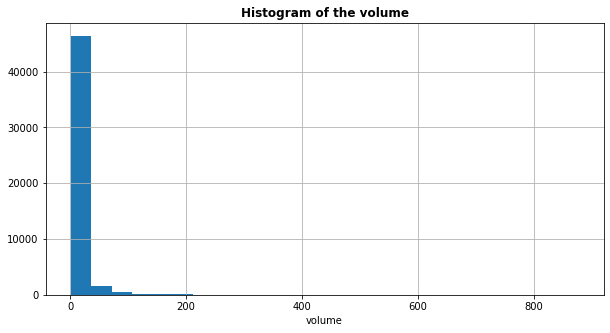

In [23]:
# Create a Histogram of the volume
data['volume'].hist(bins=25, figsize=(10, 5))
plt.xlabel("volume")
plt.title("Histogram of the volume", fontweight='bold')
plt.show()

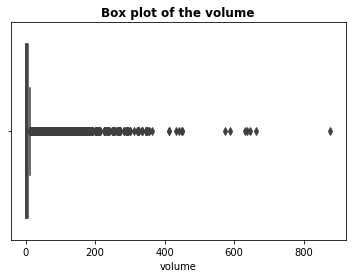

In [24]:
# Create a boxplot of the volume
sns.boxplot(data["volume"]).set_title("Box plot of the volume", fontweight='bold')
plt.show()

**Observation:** It's look like outlier in given dataset

### **Checking  target feature distribution**

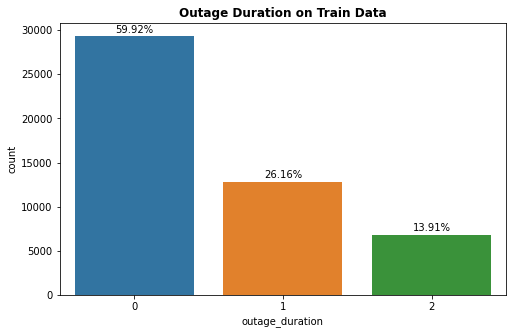

In [25]:
# Create a barplot of the outage duration
plt.figure(figsize=(8, 5))
barplot("outage_duration", data)
plt.title("Outage Duration on Train Data", fontweight='bold')
plt.show()

__Observation:__ According to the analysis **Outage 0** has 59.92% of users do not face any outage . 
    **Outage 1 and 2** are facing outage breaks more

### **Analysing Categorical Columns**

In [26]:
# See the summary statistics for categorical
data.describe(include='object')

,broadband_type,outage_type,log_report_type,transit_server_type,area_code
count,48973,48973,48973,48973,48973
unique,10,5,310,49,876
top,broadband_type_2,outage_type_1,log_report_type_312,transit_server_type_11,area_794
freq,25074,28702,3645,10494,1285


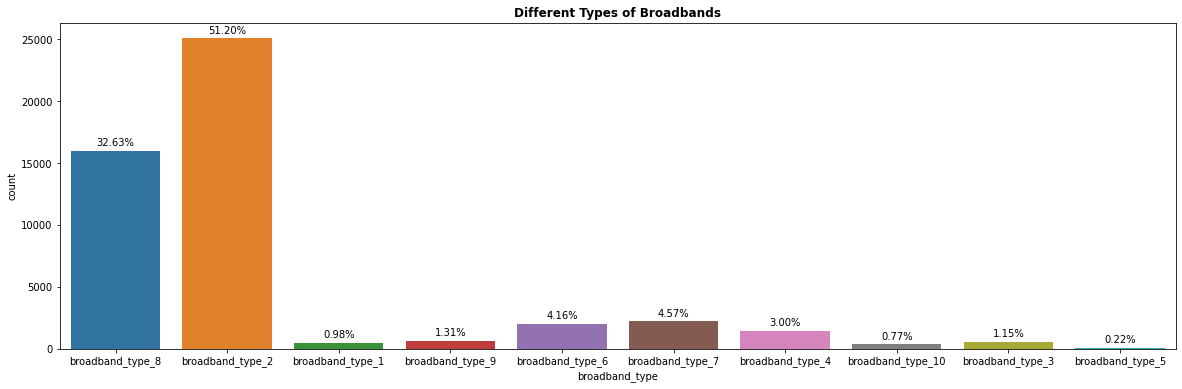

In [27]:
# Create a barplot of the broadband type
plt.figure(figsize=(20, 6))
barplot("broadband_type", data)
plt.title("Different Types of Broadbands", fontweight='bold')
plt.show()

__Observations:__ 

**Broadband types description**

    1. broadband_type_8 : 'ADSL 1'
    2. broadband_type_2 : 'ADSL 2'
    3. broadband_type_6 : 'ADSL 2+'
    4. broadband_type_7 : 'Cable'
    5. broadband_type_4 : 'Fiber 1'
    6. broadband_type_9 : 'BPL'
    7. broadband_type_3 : 'Fiber 2'
    8. broadband_type_10 : 'Fiber High Speed'
    9. broadband_type_1 : 'Fiber Ultra'
    10. broadband_type_5 : 'Fiber Ultra Max'
    
Based on analysis broadband_type_2 has the highest number of connections other than remaining broadband types.

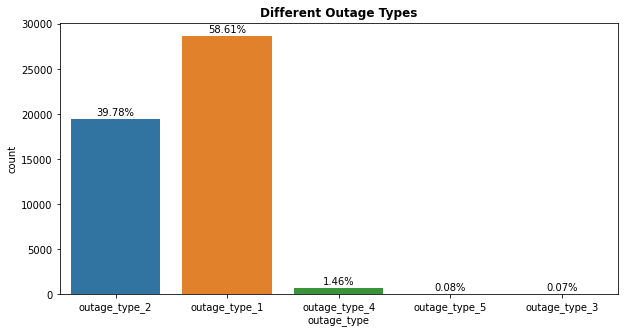

In [29]:
# Create a barplot of the outage type
plt.figure(figsize=(10, 5))
barplot("outage_type", data)
plt.title("Different Outage Types", fontweight='bold')
plt.show()

__Observation:__ According to the analysis There are 5 different types from outage type 1 to 5. 
Outage_type_1 and outage_type_2 is most repeated in the data.


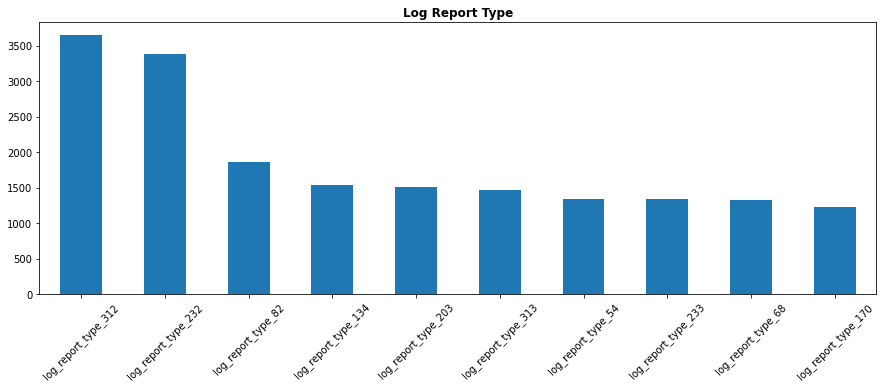

In [30]:
# Create a barplot of the log report type
plt.figure(figsize=(15, 5))
data["log_report_type"].value_counts().head(10).plot(kind="bar")
plt.xticks(rotation=45)
plt.title("Log Report Type", fontweight='bold')
plt.show()

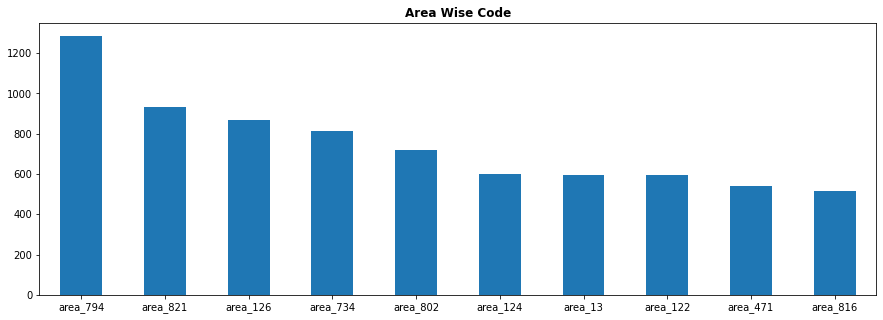

In [31]:
# Create a barplot of the area code
plt.figure(figsize=(15, 5))
data["area_code"].value_counts().head(10).plot(kind="bar")
plt.xticks(rotation=360)
plt.title("Area Wise Code", fontweight='bold')
plt.show()

__Observation:__  According to the analysis area_794 categorical column is more the `outage_duration` has been measured, followed by are_821, area_126 ..etc

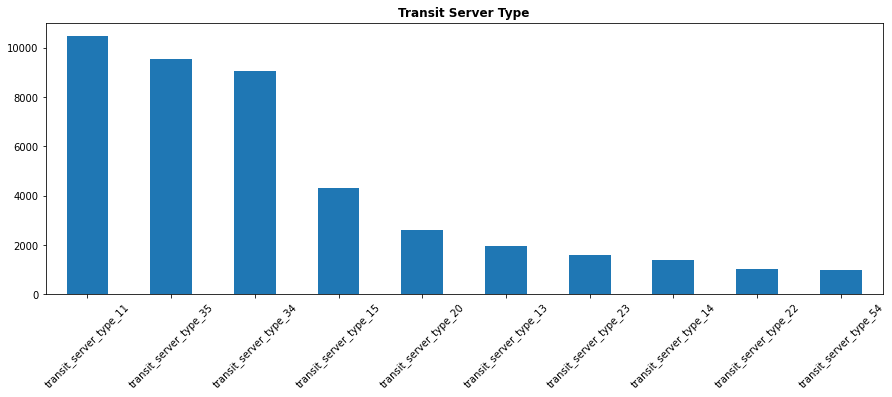

In [32]:
# Create a barplot of the transit server type
plt.figure(figsize=(15, 5))
data["transit_server_type"].value_counts().head(10).plot(kind="bar")
plt.xticks(rotation=45)
plt.title("Transit Server Type", fontweight='bold')
plt.show()

__Obervation:__ According to the analysis Server 11 has most users : 25% of users from the given data, i.e., 7888 times it has been repeated followed by transit_server_type_35, transit_server_type_34..etc

## **Bivariate non-graphical Analysis**

In [33]:
data["transit_server_type"].value_counts().head(10)/data[data["outage_duration"]==2]["transit_server_type"].value_counts()

transit_server_type_10         NaN
transit_server_type_11    5.420455
transit_server_type_13    4.148847
transit_server_type_14    3.890756
transit_server_type_15    2.780425
transit_server_type_18         NaN
transit_server_type_19         NaN
transit_server_type_2          NaN
transit_server_type_20    6.753886
transit_server_type_21         NaN
transit_server_type_22    4.855814
transit_server_type_23    9.956522
transit_server_type_24         NaN
transit_server_type_27         NaN
transit_server_type_28         NaN
transit_server_type_3          NaN
transit_server_type_31         NaN
transit_server_type_32         NaN
transit_server_type_34         NaN
transit_server_type_35         NaN
transit_server_type_38         NaN
transit_server_type_39         NaN
transit_server_type_42         NaN
transit_server_type_43         NaN
transit_server_type_44         NaN
transit_server_type_45         NaN
transit_server_type_46         NaN
transit_server_type_47         NaN
transit_server_type_

In [34]:
data[data["outage_duration"]==0]["transit_server_type"].value_counts()

transit_server_type_35    8107
transit_server_type_34    7652
transit_server_type_11    4892
transit_server_type_15    1601
transit_server_type_20    1552
transit_server_type_23     752
transit_server_type_13     669
transit_server_type_14     656
transit_server_type_22     466
transit_server_type_42     358
transit_server_type_44     352
transit_server_type_54     351
transit_server_type_43     297
transit_server_type_18     201
transit_server_type_21     168
transit_server_type_10     128
transit_server_type_26     128
transit_server_type_36      96
transit_server_type_6       83
transit_server_type_7       81
transit_server_type_40      78
transit_server_type_45      66
transit_server_type_50      61
transit_server_type_28      61
transit_server_type_47      55
transit_server_type_5       52
transit_server_type_27      47
transit_server_type_32      47
transit_server_type_24      46
transit_server_type_30      39
transit_server_type_46      34
transit_server_type_9       21
transit_

In [35]:
data.groupby("area_code").sum()["volume"].sort_values(ascending=False).head(10)

area_code
area_242     17838
area_91      16998
area_497     14416
area_1107    10693
area_495     10186
area_1100     9493
area_496      8824
area_471      8252
area_505      8244
area_821      8185
Name: volume, dtype: int64

In [36]:
data["volume"].sum()

421449

In [37]:
broaband_volume = (data.groupby("broadband_type").sum()["volume"].sort_values(ascending=False)/data["volume"].sum())*100
broaband_volume

broadband_type
broadband_type_2     59.771882
broadband_type_8     31.578910
broadband_type_7      2.541233
broadband_type_6      2.268365
broadband_type_4      1.810895
broadband_type_1      1.037373
broadband_type_9      0.336458
broadband_type_3      0.320323
broadband_type_10     0.257682
broadband_type_5      0.076878
Name: volume, dtype: float64

__Observation:__ According to the analysis 59% connections are choosen broadband 2. i.e, 'ADSL 2'.

## **Bivariate graphical Analysis**

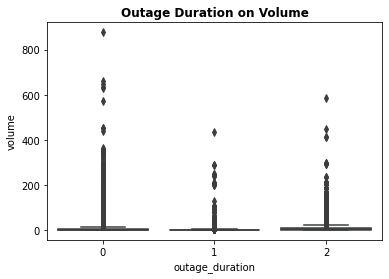

In [38]:
# Create a boxplot of the outage vs volume
sns.boxplot(x="outage_duration", y="volume", data=data)
plt.title("Outage Duration on Volume", fontweight='bold')
plt.show()

__Observation:__ It's look like more outliers in given data.

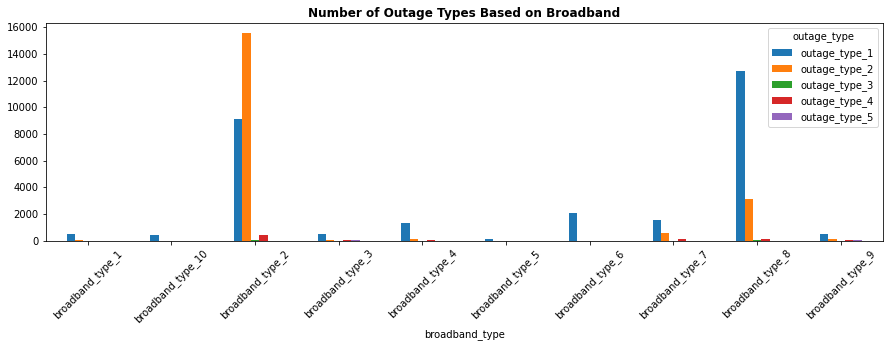

In [39]:
# Create a barplot of the broadband type vs outage type
pd.crosstab(data["broadband_type"], data["outage_type"]).plot(figsize=(15, 4), kind="bar")
plt.xticks(rotation=45)
plt.title("Number of Outage Types Based on Broadband", fontweight='bold')
plt.show()

__Observation:__ According to the analysis broadband type 2 has more outage under outage type 2.

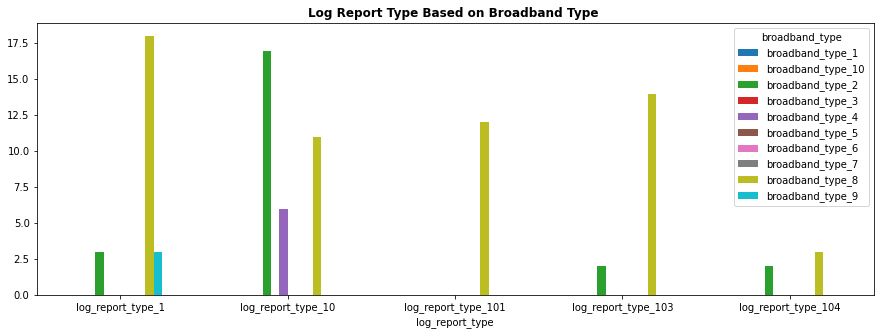

In [40]:
# Create a barplot of the log report type vs broadband type
pd.crosstab(data["log_report_type"], data["broadband_type"] ).head(5).plot(figsize=(15,5), kind="bar")
plt.xticks(rotation=360)
plt.title("Log Report Type Based on Broadband Type ", fontweight='bold')
plt.show()

__Observation:__ From the above analysis broadband_type_8 (ADSL 1) has recorded more number of log reports under log_report_type_1.

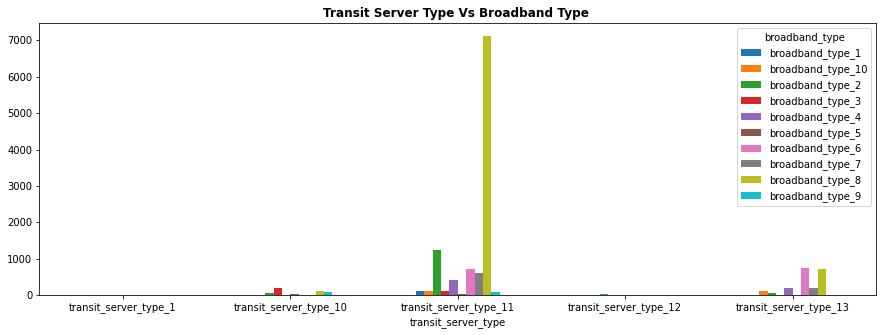

In [41]:
# Create a barplot of the transit server type vs broadband type
pd.crosstab(data["transit_server_type"], data["broadband_type"] ).head(5).plot(figsize=(15,5), kind="bar")
plt.xticks(rotation=360)
plt.title("Transit Server Type Vs Broadband Type ", fontweight='bold')
plt.show()

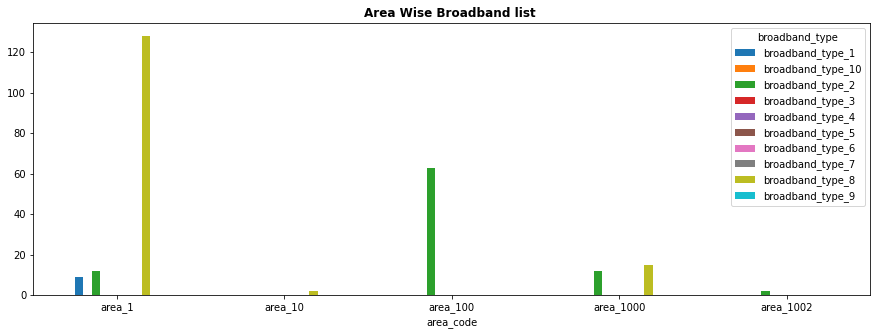

In [42]:
# Create a barplot of the area code vs broadband type
pd.crosstab(data["area_code"], data["broadband_type"] ).head().plot(figsize=(15,5), kind="bar")
plt.xticks(rotation=360)
plt.title("Area Wise Broadband list ", fontweight='bold')
plt.show()

###  **Explore the target: Outage Duration**

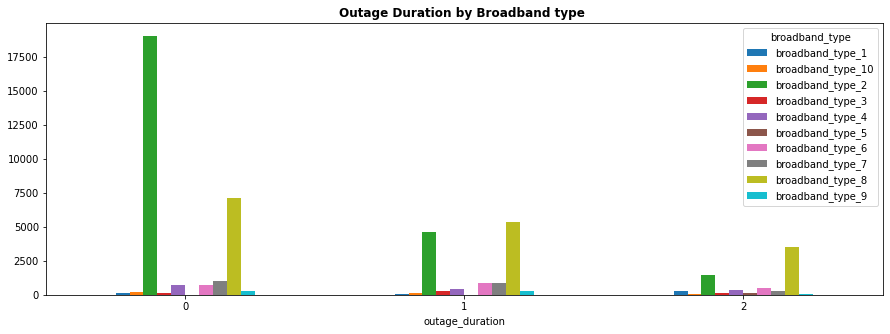

In [43]:
# Create a barplot of the outage duration vs broadband type
pd.crosstab(data["outage_duration"], data["broadband_type"] ).plot(figsize=(15,5), kind="bar")
plt.xticks(rotation=360)
plt.title("Outage Duration by Broadband type ", fontweight='bold')
plt.show()

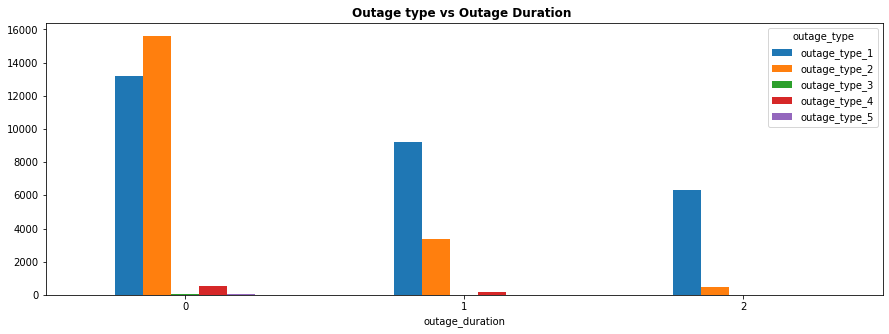

In [45]:
# Create a barplot of the outage duration vs outage type
pd.crosstab(data["outage_duration"], data["outage_type"] ).head().plot(figsize=(15,5), kind="bar")
plt.xticks(rotation=360)
plt.title("Outage type vs Outage Duration ", fontweight='bold')
plt.show()

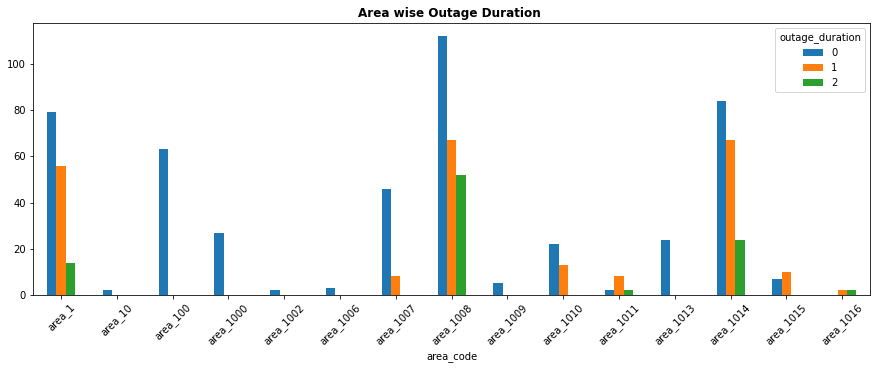

In [46]:
# Create a barplot of the outage duration vs area code
pd.crosstab(data["area_code"], data["outage_duration"] ).head(15).plot(figsize=(15,5), kind="bar")
plt.xticks(rotation=45)
plt.title("Area wise Outage Duration ", fontweight='bold')
plt.show()

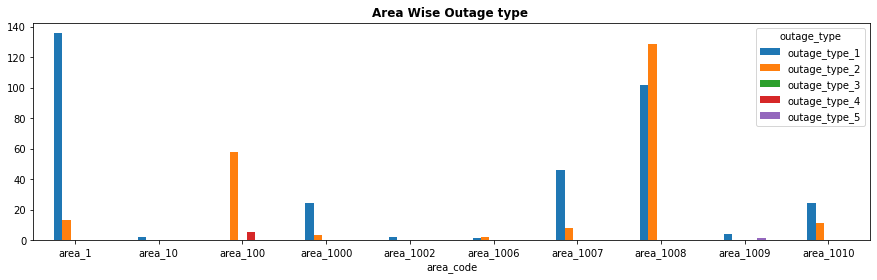

In [47]:
# Create a barplot of the area code vs outage type
pd.crosstab(data["area_code"], data["outage_type"] ).head(10).plot(figsize=(15,4), kind="bar")
plt.xticks(rotation=360)
plt.title("Area Wise Outage type ", fontweight='bold')
plt.show()

## **Improve Data Visualizations with Target Varaible**

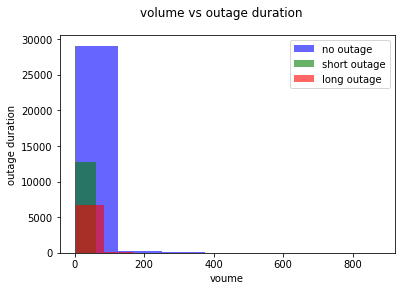

In [48]:
fig, ax = plt.subplots()

ax.hist(data[data["outage_duration"]==0]["volume"], bins=7, alpha=0.6, color="blue", label="no outage")
ax.hist(data[data["outage_duration"]==1]["volume"], bins=7, alpha=0.6, color="green", label="short outage")
ax.hist(data[data["outage_duration"]==2]["volume"], bins=7, alpha=0.6, color="red", label="long outage")

ax.set_xlabel("voume")
ax.set_ylabel("outage duration")

fig.suptitle("volume vs outage duration")

ax.legend();

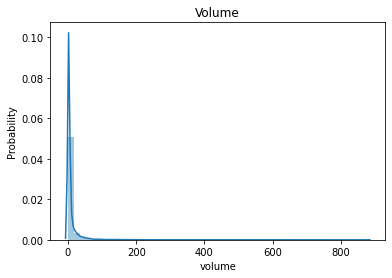

In [49]:
# Create a distplot of the volume
ax = sns.distplot(data["volume"], hist=True ,kde=True)
ax.set(ylabel='Probability', title='Volume')
plt.show()

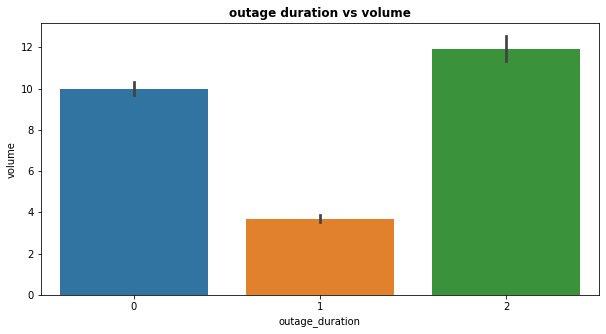

In [50]:
# Create a barplot of the outage duration vs volume
plt.figure(figsize=(10, 5))
sns.barplot(x='outage_duration',y='volume',data=data)
plt.title("outage duration vs volume", fontweight='bold')
plt.show()

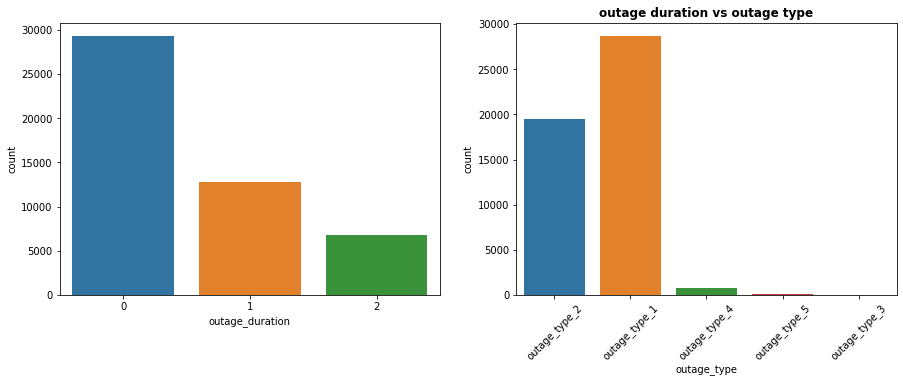

In [51]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plt.xticks(rotation=45)
sns.countplot(x="outage_duration", data=data, ax=axes[0])
sns.countplot(x="outage_type", data=data, ax=axes[1]);
plt.title("outage duration vs outage type", fontweight='bold')
plt.show()

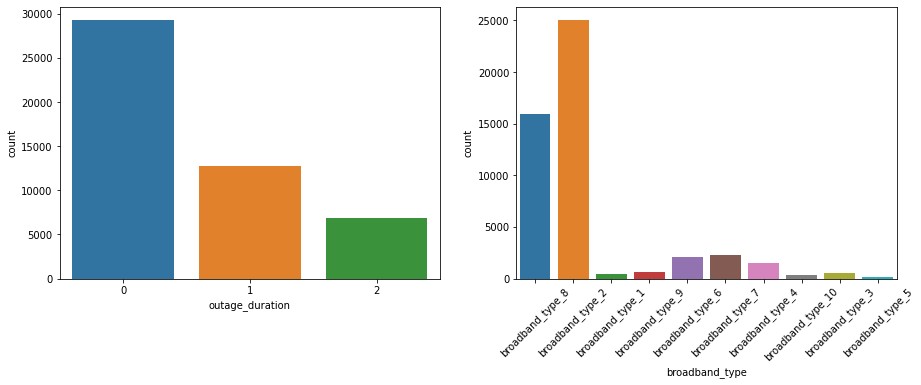

In [52]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plt.xticks(rotation=45)
sns.countplot(x="outage_duration", data=data, ax=axes[0])
sns.countplot(x="broadband_type", data=data, ax=axes[1]);

## **Feature Engineering**

In [53]:
data.shape

(48973, 8)

In [54]:
location_count = data.groupby('area_code').count()[['id']]
location_count.columns = ['location_count']
data = pd.merge(data, location_count, how='inner', left_on='area_code', right_index=True)

In [55]:
area_connections =data.groupby('broadband_type').count()[['area_code']]
area_connections.columns = ['area_connections']
data = pd.merge(data, area_connections, how='inner', left_on='broadband_type', right_index=True)

In [ ]:
outage_type_freq = data.groupby('outage_type').count()[['id']]
outage_type_freq.columns = ['outage_type_freq']
data = pd.merge(data, outage_type_freq, how='inner', left_on='outage_type', right_index=True)

In [ ]:
broadband_log_report =data.groupby('log_report_type').count()[['broadband_type']]
broadband_log_report.columns = ['broadband_log_report']
data = pd.merge(data, broadband_log_report, how='inner', left_on='log_report_type', right_index=True)

In [ ]:
broadband_traffic =data.groupby('transit_server_type').count()[['broadband_type']]
broadband_traffic.columns = ['broadband_traffic']
data = pd.merge(data, broadband_traffic, how='inner', left_on='transit_server_type', right_index=True)

In [ ]:
volume_count =data.groupby('volume').count()[['id']]
volume_count.columns = ['volume_count']
data = pd.merge(data, volume_count, how='inner', left_on='volume', right_index=True)

In [ ]:
data.head(10)

,id,broadband_type,outage_type,log_report_type,volume,transit_server_type,area_code,outage_duration,location_count,area_connections,outage_type_freq,broadband_log_report,broadband_traffic,volume_count
0,8011,broadband_type_8,outage_type_2,log_report_type_68,7,transit_server_type_15,area_1,0,149,15981,19480,1326,4318,1082
920,4591,broadband_type_8,outage_type_2,log_report_type_68,7,transit_server_type_15,area_1019,0,241,15981,19480,1326,4318,1082
523,665,broadband_type_8,outage_type_2,log_report_type_80,7,transit_server_type_15,area_1008,1,231,15981,19480,845,4318,1082
34466,9289,broadband_type_8,outage_type_2,log_report_type_80,7,transit_server_type_15,area_742,0,138,15981,19480,845,4318,1082
34470,9289,broadband_type_2,outage_type_2,log_report_type_80,7,transit_server_type_15,area_742,0,138,25074,19480,845,4318,1082
90,17041,broadband_type_8,outage_type_1,log_report_type_80,7,transit_server_type_15,area_1,1,149,15981,28702,845,4318,1082
255,2008,broadband_type_8,outage_type_1,log_report_type_80,7,transit_server_type_15,area_1007,0,54,15981,28702,845,4318,1082
298,5545,broadband_type_8,outage_type_1,log_report_type_80,7,transit_server_type_15,area_1007,0,54,15981,28702,845,4318,1082
442,8378,broadband_type_8,outage_type_1,log_report_type_80,7,transit_server_type_15,area_1008,0,231,15981,28702,845,4318,1082
503,2425,broadband_type_8,outage_type_1,log_report_type_80,7,transit_server_type_15,area_1008,1,231,15981,28702,845,4318,1082


## **Data Pre-processing**

#### **Drop column(s) which are not significant**

In [ ]:
# Remove ID
data.drop(['id'], axis = 1, inplace=True)

###  **Type Conversions**

In [ ]:
data.dtypes

broadband_type          object
outage_type             object
log_report_type         object
volume                   int64
transit_server_type     object
area_code               object
outage_duration          int64
location_count           int64
area_connections         int64
outage_type_freq         int64
broadband_log_report     int64
broadband_traffic        int64
volume_count             int64
dtype: object

**Using astype('category') to convert broadband_type, outage_type, log_report_type, transit_server_type, area_code attributes to categorical attributes.**

In [ ]:
for col in ['broadband_type', 'outage_type', 'log_report_type', 'transit_server_type', 'area_code']:
    data[col] = data[col].astype('category')

In [ ]:
data.dtypes

broadband_type          category
outage_type             category
log_report_type         category
volume                     int64
transit_server_type     category
area_code               category
outage_duration            int64
location_count             int64
area_connections           int64
outage_type_freq           int64
broadband_log_report       int64
broadband_traffic          int64
volume_count               int64
dtype: object

In [ ]:
num_attr = data.select_dtypes('int64').columns
num_attr

Index(['volume', 'outage_duration', 'location_count', 'area_connections',
       'outage_type_freq', 'broadband_log_report', 'broadband_traffic',
       'volume_count'],
      dtype='object')

In [ ]:
cat_attr = data.select_dtypes('category').columns
cat_attr

Index(['broadband_type', 'outage_type', 'log_report_type',
       'transit_server_type', 'area_code'],
      dtype='object')

### **Chi-Square test of independence**

We will perform the test using a mathematical approach and then using Python’s SciPy module.

- We start by defining the null hypothesis (H0) which states that there is no relation between the variables. 
- An alternate hypothesis(H1) would state that there is a significant relation between the two.

- Using p-value:
    * We define a significance factor to determine whether the relation between the variables is of considerable significance. 
    * Generally a significance factor or alpha value of 0.05 is chosen. This alpha value denotes the probability of erroneously rejecting H0 when it is true.

    * If the p-value for the test comes out to be strictly greater than the alpha value, then H0 holds true.
    
The chi2_contingency() function of scipy.stats module takes, 
- Input as the contingency table in 2d array format. 
- Returns a tuple containing test statistics, the p-value, degrees of freedom and expected table(the one we created from the calculated values) in that order. 

Hence, we need to compare the obtained p-value with alpha value of 0.05 (default).

In [ ]:
def find_chi2_independence(cat_attr, target, data, alpha=0.05):
    data = data[[target, cat_attr]]
    tab = sm.stats.Table.from_data(data)
    tab = tab.table_orig.to_numpy()
    print(f"---------------{target} Vs {cat_attr} Chi Square Test of Independence -------------------")
    print(f"\n Contingency table :\n")
    print(tab)
    
    stat, p, dof, expected = chi2_contingency(tab)
    print(p)
    print(f"\n Expected table :\n")
    print(expected)
    
    print(f"The p value returned = {p} and degrees of freedom returned = {dof}")
    
    # interpret p-value
    print('significance(alpha) = %.3f' % (alpha))

    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)') 

In [ ]:
for col in cat_attr:
    find_chi2_independence(col, 'outage_duration', data)

---------------outage_duration Vs broadband_type Chi Square Test of Independence -------------------

 Contingency table :

[[  172   201 19003   149   703     0   692  1052  7096   279]
 [   56   108  4615   286   402     0   848   879  5352   266]
 [  253    70  1456   126   364   110   498   306  3533    98]]
0.0

 Expected table :

[[  288.23856002   227.11520634 15025.55853225   336.17844527
    880.29614277    65.91734221  1221.26857656  1340.5190411
   9576.59132583   385.31682764]
 [  125.83611378    99.15153248  6559.69795602   146.76519715
    384.31029343    28.77748964   533.16839891   585.2294938
   4180.84601719   168.21750761]
 [   66.9253262     52.73326118  3488.74351173    78.05635758
    204.3935638     15.30516815   283.56302452   311.25146509
   2223.56265697    89.46566475]]
The p value returned = 0.0 and degrees of freedom returned = 18
significance(alpha) = 0.050
Dependent (reject H0)
---------------outage_duration Vs outage_type Chi Square Test of Independence 

__Observation:__ broadband_type, outage_type, log_report_type, transit_server_type, area_code  attributes tend to influence the target

In [ ]:
data['outage_duration'].value_counts()

0    29347
1    12812
2     6814
Name: outage_duration, dtype: int64

In [ ]:
# Convert 'outage_duration' column into categorical
data['outage_duration']= data['outage_duration'].astype('category')

In [ ]:
data.dtypes

broadband_type          category
outage_type             category
log_report_type         category
volume                     int64
transit_server_type     category
area_code               category
outage_duration         category
location_count             int64
area_connections           int64
outage_type_freq           int64
broadband_log_report       int64
broadband_traffic          int64
volume_count               int64
dtype: object

### **Split the data into train and test sets**

In [ ]:
X = data.loc[:, data.columns != 'outage_duration']
y = data['outage_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.30, random_state=123, stratify = y)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(34281, 12)
(34281,)
(14692, 12)
(14692,)


### **Split the attributes into numerical and categorical types**

In [ ]:
num_attr=X_train.select_dtypes('int64').columns
num_attr

Index(['volume', 'location_count', 'area_connections', 'outage_type_freq',
       'broadband_log_report', 'broadband_traffic', 'volume_count'],
      dtype='object')

In [ ]:
cat_attr = X_train.select_dtypes('category').columns
cat_attr

Index(['broadband_type', 'outage_type', 'log_report_type',
       'transit_server_type', 'area_code'],
      dtype='object')

In [ ]:
X_train.dtypes

broadband_type          category
outage_type             category
log_report_type         category
volume                     int64
transit_server_type     category
area_code               category
location_count             int64
area_connections           int64
outage_type_freq           int64
broadband_log_report       int64
broadband_traffic          int64
volume_count               int64
dtype: object

In [ ]:
X_train.isnull().sum()

broadband_type          0
outage_type             0
log_report_type         0
volume                  0
transit_server_type     0
area_code               0
location_count          0
area_connections        0
outage_type_freq        0
broadband_log_report    0
broadband_traffic       0
volume_count            0
dtype: int64

In [ ]:
# DataFrameMapper, a class for mapping pandas data frame columns to different sklearn transformations
mapper = DataFrameMapper(
  [([continuous_col], StandardScaler()) for continuous_col in num_attr] +
  [([categorical_col], OneHotEncoder(handle_unknown="ignore", sparse=False)) for categorical_col in cat_attr]
, df_out=True)

In [ ]:
print(type(mapper))

<class 'sklearn_pandas.dataframe_mapper.DataFrameMapper'>


In [ ]:
mapper.fit(X_train)

DataFrameMapper(df_out=True, drop_cols=[],
                features=[(['volume'], StandardScaler()),
                          (['location_count'], StandardScaler()),
                          (['area_connections'], StandardScaler()),
                          (['outage_type_freq'], StandardScaler()),
                          (['broadband_log_report'], StandardScaler()),
                          (['broadband_traffic'], StandardScaler()),
                          (['volume_count'], StandardScaler()),
                          (['broadband_type'],
                           OneHotEncoder(handle_unknown='ignore',
                                         sparse=False)),
                          (['outage_type'],
                           OneHotEncoder(handle_unknown='ignore',
                                         sparse=False)),
                          (['log_report_type'],
                           OneHotEncoder(handle_unknown='ignore',
                                         

In [ ]:
X_train_final = mapper.transform(X_train)
X_test_final = mapper.transform(X_test)

In [ ]:
X_train_final.columns

Index(['volume', 'location_count', 'area_connections', 'outage_type_freq',
       'broadband_log_report', 'broadband_traffic', 'volume_count',
       'broadband_type_x0_broadband_type_1',
       'broadband_type_x0_broadband_type_10',
       'broadband_type_x0_broadband_type_2',
       ...
       'area_code_x0_area_984', 'area_code_x0_area_989',
       'area_code_x0_area_99', 'area_code_x0_area_990',
       'area_code_x0_area_991', 'area_code_x0_area_994',
       'area_code_x0_area_995', 'area_code_x0_area_996',
       'area_code_x0_area_998', 'area_code_x0_area_999'],
      dtype='object', length=1226)

In [ ]:
X_train_final.head(10)

,volume,location_count,area_connections,outage_type_freq,broadband_log_report,broadband_traffic,volume_count,broadband_type_x0_broadband_type_1,broadband_type_x0_broadband_type_10,broadband_type_x0_broadband_type_2,...,area_code_x0_area_984,area_code_x0_area_989,area_code_x0_area_99,area_code_x0_area_990,area_code_x0_area_991,area_code_x0_area_994,area_code_x0_area_995,area_code_x0_area_996,area_code_x0_area_998,area_code_x0_area_999
38574,-0.279071,-0.873577,-0.271162,0.753503,-0.286220,-0.561683,-0.098577,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37770,-0.321790,1.562124,-1.923985,0.753503,-0.985447,-1.149284,1.181398,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16752,-0.279071,-0.716894,-0.271162,0.753503,-0.384924,0.989844,-0.098577,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40804,-0.321790,-0.065237,-1.923985,0.753503,-0.776970,-1.149284,1.181398,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18598,-0.279071,-0.627870,-0.271162,0.753503,-0.768668,0.627335,-0.098577,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2454,-0.321790,0.205396,-1.923985,0.753503,-0.393226,-1.149284,1.181398,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41698,0.233563,-0.738260,-0.271162,-0.935900,0.632552,-0.561683,-1.156090,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41153,-0.279071,-0.339432,-0.271162,0.753503,-0.286220,0.989844,-0.098577,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21400,-0.279071,-0.620748,0.806734,0.753503,0.334597,0.751939,-0.098577,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34548,-0.193632,-0.079481,-0.271162,0.753503,-0.393226,0.989844,-0.829199,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_test_final.head(10)

,volume,location_count,area_connections,outage_type_freq,broadband_log_report,broadband_traffic,volume_count,broadband_type_x0_broadband_type_1,broadband_type_x0_broadband_type_10,broadband_type_x0_broadband_type_2,...,area_code_x0_area_984,area_code_x0_area_989,area_code_x0_area_99,area_code_x0_area_990,area_code_x0_area_991,area_code_x0_area_994,area_code_x0_area_995,area_code_x0_area_996,area_code_x0_area_998,area_code_x0_area_999
13759,-0.321790,-0.788114,-0.271162,0.753503,-0.901503,0.751939,1.181398,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24788,-0.065473,0.105689,0.806734,-0.935900,-0.475325,0.751939,-1.071565,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13994,-0.193632,-0.560212,0.806734,0.753503,2.273613,0.989844,-0.829199,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28409,-0.022754,-0.521041,-0.271162,-0.935900,-0.055605,-1.384173,-1.081390,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
894,-0.279071,-0.649236,-0.271162,0.753503,-0.309282,0.989844,-0.098577,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30564,-0.108193,-0.200554,-0.271162,0.753503,0.304156,0.989844,-1.015634,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3583,-0.108193,-0.994650,-0.271162,0.753503,-0.972532,0.989844,-1.015634,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10710,-0.279071,-0.510358,0.806734,0.753503,-1.044484,0.751939,-0.098577,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45851,3.053050,0.162665,0.806734,-0.935900,2.273613,0.751939,-1.206982,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18267,-0.321790,-0.983967,0.806734,-4.373144,2.273613,0.751939,1.181398,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(X_train_final.shape)
print(y_train.shape)
print(X_test_final.shape)
print(y_test.shape)

(34281, 1226)
(34281,)
(14692, 1226)
(14692,)


In [ ]:
data.outage_duration.value_counts(normalize=True)*100

0    59.924857
1    26.161354
2    13.913789
Name: outage_duration, dtype: float64

In [ ]:
y_train.value_counts(normalize=True)*100

0    59.925323
1    26.160264
2    13.914413
Name: outage_duration, dtype: float64

In [ ]:
y_test.value_counts(normalize = True)*100

0    59.923768
1    26.163899
2    13.912333
Name: outage_duration, dtype: float64

###  **Defining Error Metrics**

In [ ]:
def model_evaluation(train_actual,train_predicted,test_actual,test_predicted):
    print('''
             ========================================
               CLASSIFICATION REPORT FOR TRAIN DATA
             ========================================
        ''')
    print(classification_report(train_actual, train_predicted, digits=4))

    print('''
             =========================================
               CLASSIFICATION REPORT FOR TEST DATA
             =========================================
            ''')
    print(classification_report(test_actual, test_predicted, digits=4))

    print('''
 ========================================
   Confusion Matrix FOR TRAIN DATA
 ========================================
            ''')
    print(confusion_matrix(train_actual, train_predicted))

    print('''
 =========================================
   Confusion matrix FOR TEST DATA
 =========================================
            ''')
    print(confusion_matrix(test_actual, test_predicted))

In [ ]:
scores = pd.DataFrame(columns=['Model','Train_Accuracy','Train_Recall','Train_Precision','Train_F1_Score','Test_Accuracy','Test_Recall','Test_Precision','Test_F1_Score'])

def get_metrics(train_actual,train_predicted,test_actual,test_predicted,model_description,dataframe):
    model_evaluation(train_actual,train_predicted,test_actual,test_predicted)
    train_accuracy = accuracy_score(train_actual,train_predicted)
    train_recall   = recall_score(train_actual,train_predicted, average='macro')
    train_precision= precision_score(train_actual,train_predicted, average='macro')
    train_f1score  = f1_score(train_actual,train_predicted, average='macro')
    test_accuracy = accuracy_score(test_actual,test_predicted)
    test_recall   = recall_score(test_actual,test_predicted, average='macro')
    test_precision= precision_score(test_actual,test_predicted, average='macro')
    test_f1score  = f1_score(test_actual,test_predicted, average='macro')
    dataframe = dataframe.append(pd.Series([model_description, train_accuracy,train_recall,train_precision,train_f1score,
                                            test_accuracy,test_recall,test_precision,test_f1score],
                                           index=scores.columns ), ignore_index=True)
    return(dataframe)

## **MODEL BUILDING**

### **1. Logistic Regression**

In [ ]:
# Create Logistic Regression object
log_mod = LogisticRegression(random_state=123)

In [ ]:
# Train the Classifer
%time log_mod.fit(X_train_final, y_train)

Wall time: 11.2 s


LogisticRegression(random_state=123)

In [ ]:
# Predict
y_pred_train = log_mod.predict(X_train_final)
y_pred_test = log_mod.predict(X_test_final)

##### **Evaluating the model performance**

In [ ]:
# Model score
scores = get_metrics(y_train, y_pred_train, y_test, y_pred_test, "LogisticRegression", scores)
scores


               CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.8579    0.8748    0.8663     20543
           1     0.7229    0.6475    0.6831      8968
           2     0.6879    0.7644    0.7241      4770

    accuracy                         0.8000     34281
   macro avg     0.7563    0.7622    0.7579     34281
weighted avg     0.7990    0.8000    0.7986     34281


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.8470    0.8628    0.8548      8804
           1     0.6959    0.6288    0.6607      3844
           2     0.6690    0.7368    0.7013      2044

    accuracy                         0.7840     14692
   macro avg     0.7373    0.7428    0.7389     14692
weighted avg     0.7827    0.7840    0.7827     14692


   Confusion Matrix FOR TRAIN DATA
            
[[17972  1724   847]
 [ 2354  5807   807]
 [  622   502  3646]

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.800006,0.762244,0.756251,0.757859,0.784032,0.742784,0.737329,0.738921


### **2. Decision Tree Classifier**

In [ ]:
# Create Decision Tree classifer object
clf_dt = DecisionTreeClassifier(random_state=123)

# Train the Classifer
%time clf_dt.fit(X_train_final, y_train)

Wall time: 5.7 s


DecisionTreeClassifier(random_state=123)

In [ ]:
# Predict
y_pred_train = clf_dt.predict(X_train_final)
y_pred_test = clf_dt.predict(X_test_final)

##### **Evaluating the model performance**

In [ ]:
# model score
scores = get_metrics(y_train, y_pred_train, y_test, y_pred_test, "DecisionTree", scores)
scores


               CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.9423    0.9898    0.9655     20543
           1     0.9470    0.8895    0.9174      8968
           2     0.9792    0.8786    0.9262      4770

    accuracy                         0.9481     34281
   macro avg     0.9562    0.9193    0.9364     34281
weighted avg     0.9487    0.9481    0.9474     34281


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.8882    0.9081    0.8981      8804
           1     0.7681    0.7625    0.7653      3844
           2     0.8336    0.7647    0.7977      2044

    accuracy                         0.8501     14692
   macro avg     0.8300    0.8118    0.8203     14692
weighted avg     0.8492    0.8501    0.8494     14692


   Confusion Matrix FOR TRAIN DATA
            
[[20334   166    43]
 [  945  7977    46]
 [  299   280  4191]

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.800006,0.762244,0.756251,0.757859,0.784032,0.742784,0.737329,0.738921
1,DecisionTree,0.948105,0.919313,0.956201,0.936354,0.850054,0.811758,0.829972,0.820330


In [ ]:
clf_dt.feature_importances_

array([7.86358300e-02, 1.39375622e-01, 1.78187041e-02, ...,
       9.28080929e-05, 0.00000000e+00, 8.78857671e-05])

In [ ]:
X_test_final.columns

Index(['volume', 'location_count', 'area_connections', 'outage_type_freq',
       'broadband_log_report', 'broadband_traffic', 'volume_count',
       'broadband_type_x0_broadband_type_1',
       'broadband_type_x0_broadband_type_10',
       'broadband_type_x0_broadband_type_2',
       ...
       'area_code_x0_area_984', 'area_code_x0_area_989',
       'area_code_x0_area_99', 'area_code_x0_area_990',
       'area_code_x0_area_991', 'area_code_x0_area_994',
       'area_code_x0_area_995', 'area_code_x0_area_996',
       'area_code_x0_area_998', 'area_code_x0_area_999'],
      dtype='object', length=1226)

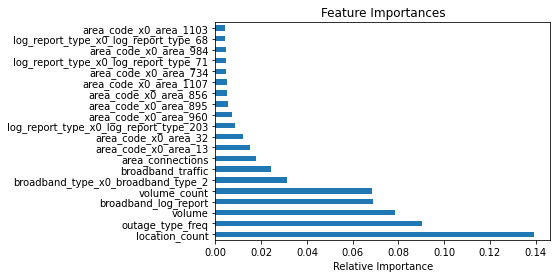

In [ ]:
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.show(pd.Series(clf_dt.feature_importances_, index=X_test_final.columns).nlargest(20).plot(kind='barh'))

### **3. KNN Classifier**

In [ ]:
# Create knn classifer object
clf_knn= KNeighborsClassifier(n_neighbors=5, metric="euclidean")

# Train the classifer
%time clf_knn.fit(X_train_final, y_train)

CPU times: user 7.64 s, sys: 16.9 ms, total: 7.66 s
Wall time: 7.67 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
# Predict
y_pred_train = clf_knn.predict(X_train_final)
y_pred_test = clf_knn.predict(X_test_final)

#### **Evaluating the model performance**

In [ ]:
# model score
scores = get_metrics(y_train, y_pred_train, y_test, y_pred_test, "KNN", scores)
scores


               CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.8634    0.9238    0.8926     20543
           1     0.7717    0.7109    0.7400      8968
           2     0.8502    0.7201    0.7798      4770

    accuracy                         0.8397     34281
   macro avg     0.8284    0.7849    0.8041     34281
weighted avg     0.8376    0.8397    0.8370     34281


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.8088    0.8713    0.8389      8804
           1     0.6353    0.5747    0.6035      3844
           2     0.7348    0.6223    0.6739      2044

    accuracy                         0.7591     14692
   macro avg     0.7263    0.6894    0.7054     14692
weighted avg     0.7531    0.7591    0.7544     14692


   Confusion Matrix FOR TRAIN DATA
            
[[18977  1285   281]
 [ 2269  6375   324]
 [  734   601  3435]

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.800006,0.762244,0.756251,0.757859,0.784032,0.742784,0.737329,0.738921
1,DecisionTree,0.948105,0.919313,0.956201,0.936354,0.850054,0.811758,0.829972,0.820330
2,KNN,0.839736,0.784919,0.828441,0.804126,0.759053,0.689427,0.726330,0.705429


### **4. Naive Bayes Classifier**

In [ ]:
# Create naive bayes classifer object
clf_naive = GaussianNB()

# Train the classifer
%time clf_naive.fit(X_train_final, y_train)

CPU times: user 501 ms, sys: 46 ms, total: 547 ms
Wall time: 550 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
# Predict
y_pred_train = clf_naive.predict(X_train_final)
y_pred_test = clf_naive.predict(X_test_final)

#### **Evaluating the model performance**

In [ ]:
# model score
scores = get_metrics(y_train, y_pred_train, y_test, y_pred_test, "NaiveBayes", scores)
scores


               CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.9976    0.4761    0.6445     20543
           1     0.4512    0.6317    0.5264      8968
           2     0.4001    1.0000    0.5715      4770

    accuracy                         0.5897     34281
   macro avg     0.6163    0.7026    0.5808     34281
weighted avg     0.7715    0.5897    0.6035     34281


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.9912    0.4747    0.6419      8804
           1     0.4442    0.6225    0.5185      3844
           2     0.3995    0.9946    0.5700      2044

    accuracy                         0.5857     14692
   macro avg     0.6116    0.6973    0.5768     14692
weighted avg     0.7658    0.5857    0.5996     14692


   Confusion Matrix FOR TRAIN DATA
            
[[9780 6890 3873]
 [  24 5665 3279]
 [   0    0 4770]]

   Con

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.800006,0.762244,0.756251,0.757859,0.784032,0.742784,0.737329,0.738921
1,DecisionTree,0.948105,0.919313,0.956201,0.936354,0.850054,0.811758,0.829972,0.820330
2,KNN,0.839736,0.784919,0.828441,0.804126,0.759053,0.689427,0.726330,0.705429
3,NaiveBayes,0.589685,0.702588,0.616289,0.580830,0.585693,0.697273,0.611644,0.576811


### **5. SVM (Linear)**

In [ ]:
# Create a SVM classifier using a linear kernel
linear_svm = SVC(kernel='linear')

In [ ]:
# Train the classifier
%time linear_svm.fit(X_train_final, y_train)

CPU times: user 44min 37s, sys: 2.09 s, total: 44min 39s
Wall time: 44min 28s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# Predict
y_pred_train= linear_svm.predict(X_train_final)
y_pred_test = linear_svm.predict(X_test_final)

#### **Evaluating the model performance**

In [ ]:
# Model score
scores = get_metrics(y_train, y_pred_train, y_test, y_pred_test, "SVM(Linear)", scores)
scores


               CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.8611    0.8749    0.8679     20543
           1     0.7228    0.6488    0.6838      8968
           2     0.6987    0.7851    0.7394      4770

    accuracy                         0.8032     34281
   macro avg     0.7609    0.7696    0.7637     34281
weighted avg     0.8023    0.8032    0.8019     34281


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.8489    0.8628    0.8558      8804
           1     0.6888    0.6246    0.6551      3844
           2     0.6802    0.7515    0.7141      2044

    accuracy                         0.7850     14692
   macro avg     0.7393    0.7463    0.7417     14692
weighted avg     0.7835    0.7850    0.7836     14692


   Confusion Matrix FOR TRAIN DATA
            
[[17973  1757   813]
 [ 2348  5818   802]
 [  551   474  3745]

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.800006,0.762244,0.756251,0.757859,0.784032,0.742784,0.737329,0.738921
1,DecisionTree,0.948105,0.919313,0.956201,0.936354,0.850054,0.811758,0.829972,0.820330
2,KNN,0.839736,0.784919,0.828441,0.804126,0.759053,0.689427,0.726330,0.705429
3,NaiveBayes,0.589685,0.702588,0.616289,0.580830,0.585693,0.697273,0.611644,0.576811
4,SVM(Linear),0.803244,0.769588,0.760874,0.763707,0.784985,0.746289,0.739303,0.741664


### **6. Random Forest Classifier**

In [ ]:
#Create a Random Forest Classifier
clf_rf = RandomForestClassifier()

#Train the classifier
%time clf_rf.fit(X_train_final, y_train)

CPU times: user 29.6 s, sys: 45.9 ms, total: 29.7 s
Wall time: 29.6 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# Predict
y_pred_train= clf_rf.predict(X_train_final)
y_pred_test = clf_rf.predict(X_test_final)

#### Evaluating the model performance

In [ ]:
# Model score
scores = get_metrics(y_train, y_pred_train, y_test, y_pred_test, "RandomForest", scores)
scores


               CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.9612    0.9700    0.9656     20543
           1     0.9237    0.9136    0.9186      8968
           2     0.9363    0.9189    0.9275      4770

    accuracy                         0.9481     34281
   macro avg     0.9404    0.9341    0.9372     34281
weighted avg     0.9479    0.9481    0.9480     34281


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.8653    0.8870    0.8760      8804
           1     0.7224    0.6782    0.6996      3844
           2     0.7415    0.7466    0.7440      2044

    accuracy                         0.8128     14692
   macro avg     0.7764    0.7706    0.7732     14692
weighted avg     0.8107    0.8128    0.8115     14692


   Confusion Matrix FOR TRAIN DATA
            
[[19926   476   141]
 [  618  8193   157]
 [  186   201  4383]

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.800006,0.762244,0.756251,0.757859,0.784032,0.742784,0.737329,0.738921
1,DecisionTree,0.948105,0.919313,0.956201,0.936354,0.850054,0.811758,0.829972,0.820330
2,KNN,0.839736,0.784919,0.828441,0.804126,0.759053,0.689427,0.726330,0.705429
3,NaiveBayes,0.589685,0.702588,0.616289,0.580830,0.585693,0.697273,0.611644,0.576811
4,SVM(Linear),0.803244,0.769588,0.760874,0.763707,0.784985,0.746289,0.739303,0.741664
5,RandomForest,0.948105,0.934138,0.940410,0.937231,0.812823,0.770586,0.776374,0.773200


### **7. Gradient Boosting Classifier**

In [ ]:
#Create a Gradient Boosting Classifier object
clf_GBM = GradientBoostingClassifier(n_estimators=50,
                                       learning_rate=0.3,
                                       subsample=0.8)

In [ ]:
#Train the classifier
%time clf_GBM.fit(X_train_final, y_train)

CPU times: user 3min 5s, sys: 149 ms, total: 3min 5s
Wall time: 3min 4s


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.3, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
# Predict
y_pred_train = clf_GBM.predict(X_train_final)
y_pred_test = clf_GBM.predict(X_test_final)

#### **Evaluating the model performance**

In [ ]:
# Model score
scores = get_metrics(y_train, y_pred_train, y_test, y_pred_test, "GradientBoosting", scores)
scores


               CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.7879    0.9138    0.8462     20543
           1     0.7062    0.5103    0.5924      8968
           2     0.7662    0.6382    0.6963      4770

    accuracy                         0.7699     34281
   macro avg     0.7534    0.6874    0.7117     34281
weighted avg     0.7635    0.7699    0.7590     34281


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.7807    0.9069    0.8391      8804
           1     0.6889    0.4909    0.5733      3844
           2     0.7404    0.6252    0.6780      2044

    accuracy                         0.7588     14692
   macro avg     0.7367    0.6743    0.6968     14692
weighted avg     0.7511    0.7588    0.7471     14692


   Confusion Matrix FOR TRAIN DATA
            
[[18773  1331   439]
 [ 3902  4576   490]
 [ 1153   573  3044]

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.800006,0.762244,0.756251,0.757859,0.784032,0.742784,0.737329,0.738921
1,DecisionTree,0.948105,0.919313,0.956201,0.936354,0.850054,0.811758,0.829972,0.820330
2,KNN,0.839736,0.784919,0.828441,0.804126,0.759053,0.689427,0.726330,0.705429
3,NaiveBayes,0.589685,0.702588,0.616289,0.580830,0.585693,0.697273,0.611644,0.576811
4,SVM(Linear),0.803244,0.769588,0.760874,0.763707,0.784985,0.746289,0.739303,0.741664
5,RandomForest,0.948105,0.934138,0.940410,0.937231,0.812823,0.770586,0.776374,0.773200
6,GradientBoosting,0.769902,0.687418,0.753400,0.711650,0.758848,0.674333,0.736685,0.696777


### **8. Light Gradient Boosting Machine (LGBM)**

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
# Create a LGBM classifier object
clf_lgbm = LGBMClassifier(n_estimators=5000)

In [ ]:
# Train the classifier
%time clf_lgbm.fit(X_train_final, y_train)

CPU times: user 2min 4s, sys: 1.98 s, total: 2min 6s
Wall time: 1min 4s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=5000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# Predict
y_pred_train = clf_lgbm.predict(X_train_final)
y_pred_test = clf_lgbm.predict(X_test_final)

#### **Evaluating the model performance**

In [ ]:
# Model score
scores = get_metrics(y_train, y_pred_train, y_test, y_pred_test, "LGBMClassifier", scores)
scores


               CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.9543    0.9628    0.9585     20543
           1     0.9089    0.8948    0.9018      8968
           2     0.9268    0.9184    0.9226      4770

    accuracy                         0.9388     34281
   macro avg     0.9300    0.9254    0.9277     34281
weighted avg     0.9386    0.9388    0.9387     34281


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.8924    0.8996    0.8960      8804
           1     0.7655    0.7534    0.7594      3844
           2     0.8029    0.7989    0.8009      2044

    accuracy                         0.8473     14692
   macro avg     0.8203    0.8173    0.8188     14692
weighted avg     0.8467    0.8473    0.8470     14692


   Confusion Matrix FOR TRAIN DATA
            
[[19778   607   158]
 [  755  8025   188]
 [  192   197  4381]

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.800006,0.762244,0.756251,0.757859,0.784032,0.742784,0.737329,0.738921
1,DecisionTree,0.948105,0.919313,0.956201,0.936354,0.850054,0.811758,0.829972,0.820330
2,KNN,0.839736,0.784919,0.828441,0.804126,0.759053,0.689427,0.726330,0.705429
3,NaiveBayes,0.589685,0.702588,0.616289,0.580830,0.585693,0.697273,0.611644,0.576811
4,SVM(Linear),0.803244,0.769588,0.760874,0.763707,0.784985,0.746289,0.739303,0.741664
5,RandomForest,0.948105,0.934138,0.940410,0.937231,0.812823,0.770586,0.776374,0.773200
6,GradientBoosting,0.769902,0.687418,0.753400,0.711650,0.758848,0.674333,0.736685,0.696777
7,LGBMClassifier,0.938829,0.925353,0.930015,0.927653,0.847332,0.817299,0.820259,0.818756


### **9. Adaboost Classifier**

In [ ]:
# Create AdaBoost classifer object
clf_ada = AdaBoostClassifier(DecisionTreeClassifier(criterion="gini", class_weight='balanced'), n_estimators=100, learning_rate = 0.4, random_state=123)

In [ ]:
# Train the classifer
%time clf_ada.fit(X_train_final, y_train)

CPU times: user 5min 20s, sys: 317 ms, total: 5min 20s
Wall time: 5min 18s


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight='balanced',
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                 

In [ ]:
# Predict
y_pred_train = clf_ada.predict(X_train_final)
y_pred_test = clf_ada.predict(X_test_final)

#### **Evaluating the model performance**

In [ ]:
# Model score
scores = get_metrics(y_train, y_pred_train, y_test, y_pred_test, "Adaboost", scores)
scores


               CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.9933    0.9284    0.9598     20543
           1     0.8779    0.9553    0.9149      8968
           2     0.8700    0.9706    0.9176      4770

    accuracy                         0.9413     34281
   macro avg     0.9137    0.9514    0.9308     34281
weighted avg     0.9460    0.9413    0.9422     34281


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.8776    0.8610    0.8692      8804
           1     0.6969    0.7029    0.6999      3844
           2     0.7213    0.7686    0.7442      2044

    accuracy                         0.8068     14692
   macro avg     0.7653    0.7775    0.7711     14692
weighted avg     0.8086    0.8068    0.8075     14692


   Confusion Matrix FOR TRAIN DATA
            
[[19072  1076   395]
 [  104  8567   297]
 [   24   116  4630]

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.800006,0.762244,0.756251,0.757859,0.784032,0.742784,0.737329,0.738921
1,DecisionTree,0.948105,0.919313,0.956201,0.936354,0.850054,0.811758,0.829972,0.820330
2,KNN,0.839736,0.784919,0.828441,0.804126,0.759053,0.689427,0.726330,0.705429
3,NaiveBayes,0.589685,0.702588,0.616289,0.580830,0.585693,0.697273,0.611644,0.576811
4,SVM(Linear),0.803244,0.769588,0.760874,0.763707,0.784985,0.746289,0.739303,0.741664
5,RandomForest,0.948105,0.934138,0.940410,0.937231,0.812823,0.770586,0.776374,0.773200
6,GradientBoosting,0.769902,0.687418,0.753400,0.711650,0.758848,0.674333,0.736685,0.696777
7,LGBMClassifier,0.938829,0.925353,0.930015,0.927653,0.847332,0.817299,0.820259,0.818756
8,Adaboost,0.941309,0.951443,0.913721,0.930754,0.806766,0.777492,0.765285,0.771108


### **10. XGBoost Classifier**

In [ ]:
# Create XGBoost classifer object
clf_XGB = XGBClassifier(n_estimators=200, gamma=0.5,learning_rate=0.3,n_jobs=-1)

#Train the classifer
%time clf_XGB.fit(X_train_final, y_train)

CPU times: user 11min 47s, sys: 795 ms, total: 11min 48s
Wall time: 6min


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5,
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# Predict
y_pred_train = clf_XGB.predict(X_train_final)
y_pred_val = clf_XGB.predict(X_test_final)

#### **Evaluating the model performance**

In [ ]:
# Model score
scores = get_metrics(y_train, y_pred_train, y_test, y_pred_test, "XGBoost", scores)
scores


               CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.8218    0.9061    0.8619     20543
           1     0.7398    0.5783    0.6491      8968
           2     0.7322    0.7090    0.7204      4770

    accuracy                         0.7929     34281
   macro avg     0.7646    0.7311    0.7438     34281
weighted avg     0.7879    0.7929    0.7866     34281


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.8776    0.8610    0.8692      8804
           1     0.6969    0.7029    0.6999      3844
           2     0.7213    0.7686    0.7442      2044

    accuracy                         0.8068     14692
   macro avg     0.7653    0.7775    0.7711     14692
weighted avg     0.8086    0.8068    0.8075     14692


   Confusion Matrix FOR TRAIN DATA
            
[[18615  1297   631]
 [ 3176  5186   606]
 [  861   527  3382]

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.800006,0.762244,0.756251,0.757859,0.784032,0.742784,0.737329,0.738921
1,DecisionTree,0.948105,0.919313,0.956201,0.936354,0.850054,0.811758,0.829972,0.820330
2,KNN,0.839736,0.784919,0.828441,0.804126,0.759053,0.689427,0.726330,0.705429
3,NaiveBayes,0.589685,0.702588,0.616289,0.580830,0.585693,0.697273,0.611644,0.576811
4,SVM(Linear),0.803244,0.769588,0.760874,0.763707,0.784985,0.746289,0.739303,0.741664
5,RandomForest,0.948105,0.934138,0.940410,0.937231,0.812823,0.770586,0.776374,0.773200
6,GradientBoosting,0.769902,0.687418,0.753400,0.711650,0.758848,0.674333,0.736685,0.696777
7,LGBMClassifier,0.938829,0.925353,0.930015,0.927653,0.847332,0.817299,0.820259,0.818756
8,Adaboost,0.941309,0.951443,0.913721,0.930754,0.806766,0.777492,0.765285,0.771108
9,XGBoost,0.792947,0.731147,0.764592,0.743822,0.806766,0.777492,0.765285,0.771108


### **Convert dataframe to numpy array to feed into Neural Networks**

In [ ]:
X_train_arr = X_train_final.values
#y_train_arr = y_train.values
X_test_arr = X_test_final.values
#y_test_arr = y_test.values

In [ ]:
print(type(X_train_arr))
print(type(X_test_arr))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
X_train_arr.shape

(34281, 1226)

In [ ]:
# Taking input_shape
input_shape = X_train_arr.shape[1]
print(input_shape)

1226


## **11. Model 1 (1 hidden layer)**

In [ ]:
model = Sequential()
model.add(Dense(32, input_dim=input_shape, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1, activation='sigmoid',kernel_initializer='glorot_normal'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                39264     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 39,297
Trainable params: 39,297
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1, min_delta=0.001)

In [ ]:
callbacks=[early_stopping]

In [ ]:
perceptron_model_history = model.fit(X_train_arr, y_train, epochs=50, batch_size=64, validation_split=0.2,callbacks=callbacks)

Epoch 1/50
429/429 [==============================] - 2s 3ms/step - loss: 0.2537 - accuracy: 0.5832 - val_loss: -0.1134 - val_accuracy: 0.6366
Epoch 2/50
429/429 [==============================] - 1s 2ms/step - loss: -0.5589 - accuracy: 0.6476 - val_loss: -1.1171 - val_accuracy: 0.6622
Epoch 3/50
429/429 [==============================] - 1s 2ms/step - loss: -1.8752 - accuracy: 0.6596 - val_loss: -2.7158 - val_accuracy: 0.6625
Epoch 4/50
429/429 [==============================] - 1s 2ms/step - loss: -3.7840 - accuracy: 0.6619 - val_loss: -4.8845 - val_accuracy: 0.6531
Epoch 5/50
429/429 [==============================] - 1s 2ms/step - loss: -6.2595 - accuracy: 0.6606 - val_loss: -7.5785 - val_accuracy: 0.6482
Epoch 6/50
429/429 [==============================] - 1s 2ms/step - loss: -9.2668 - accuracy: 0.6618 - val_loss: -10.8009 - val_accuracy: 0.6510
Epoch 7/50
429/429 [==============================] - 1s 2ms/step - loss: -12.7572 - accuracy: 0.6623 - val_loss: -14.4626 - val_accurac

In [ ]:
train_pred_1=model.predict_classes(X_train_arr)
test_pred_1=model.predict_classes(X_test_arr)

In [ ]:
scores = get_metrics(y_train,train_pred_1,y_test,test_pred_1,"1 layer model",scores)
scores


               CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.9209    0.7133    0.8039     20543
           1     0.4215    0.8633    0.5664      8968
           2     0.0000    0.0000    0.0000      4770

    accuracy                         0.6533     34281
   macro avg     0.4474    0.5255    0.4568     34281
weighted avg     0.6621    0.6533    0.6299     34281


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.9039    0.7050    0.7922      8804
           1     0.4089    0.8325    0.5485      3844
           2     0.0000    0.0000    0.0000      2044

    accuracy                         0.6403     14692
   macro avg     0.4376    0.5125    0.4469     14692
weighted avg     0.6486    0.6403    0.6182     14692


   Confusion Matrix FOR TRAIN DATA
            
[[14653  5890     0]
 [ 1226  7742     0]
 [   33  4737     0]

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.800006,0.762244,0.756251,0.757859,0.784032,0.742784,0.737329,0.738921
1,DecisionTree,0.948105,0.919313,0.956201,0.936354,0.850054,0.811758,0.829972,0.820330
2,KNN,0.839736,0.784919,0.828441,0.804126,0.759053,0.689427,0.726330,0.705429
3,NaiveBayes,0.589685,0.702588,0.616289,0.580830,0.585693,0.697273,0.611644,0.576811
4,SVM(Linear),0.803244,0.769588,0.760874,0.763707,0.784985,0.746289,0.739303,0.741664
5,RandomForest,0.948105,0.934138,0.940410,0.937231,0.812823,0.770586,0.776374,0.773200
6,GradientBoosting,0.769902,0.687418,0.753400,0.711650,0.758848,0.674333,0.736685,0.696777
7,LGBMClassifier,0.938829,0.925353,0.930015,0.927653,0.847332,0.817299,0.820259,0.818756
8,Adaboost,0.941309,0.951443,0.913721,0.930754,0.806766,0.777492,0.765285,0.771108
9,XGBoost,0.792947,0.731147,0.764592,0.743822,0.806766,0.777492,0.765285,0.771108


## **12. Model 2 - Experiment 1 (2 hidden layers)**

In [ ]:
model = Sequential()
model.add(Dense(16, input_dim=input_shape, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(12, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1, activation='sigmoid',kernel_initializer='glorot_normal'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                19632     
_________________________________________________________________
dense_3 (Dense)              (None, 12)                204       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 13        
Total params: 19,849
Trainable params: 19,849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train_arr, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=callbacks)

Epoch 1/50
429/429 [==============================] - 2s 3ms/step - loss: 0.1600 - accuracy: 0.5729 - val_loss: -0.5521 - val_accuracy: 0.6265
Epoch 2/50
429/429 [==============================] - 1s 2ms/step - loss: -2.9169 - accuracy: 0.6527 - val_loss: -6.9709 - val_accuracy: 0.6516
Epoch 3/50
429/429 [==============================] - 1s 2ms/step - loss: -15.6933 - accuracy: 0.6530 - val_loss: -27.0587 - val_accuracy: 0.6526
Epoch 4/50
429/429 [==============================] - 1s 2ms/step - loss: -44.2163 - accuracy: 0.6510 - val_loss: -64.3747 - val_accuracy: 0.6453
Epoch 5/50
429/429 [==============================] - 1s 2ms/step - loss: -92.2920 - accuracy: 0.6506 - val_loss: -122.6004 - val_accuracy: 0.6443
Epoch 6/50
429/429 [==============================] - 1s 2ms/step - loss: -163.3537 - accuracy: 0.6495 - val_loss: -204.7793 - val_accuracy: 0.6376
Epoch 7/50
429/429 [==============================] - 1s 2ms/step - loss: -258.3622 - accuracy: 0.6502 - val_loss: -311.0557 -

In [ ]:
train_pred_2=model.predict_classes(X_train_arr)
test_pred_2=model.predict_classes(X_test_arr)

In [ ]:
scores = get_metrics(y_train, train_pred_2, y_test, test_pred_2, "2 layer model - experiment 1", scores)
scores


               CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.8946    0.7292    0.8035     20543
           1     0.4135    0.8087    0.5472      8968
           2     0.0000    0.0000    0.0000      4770

    accuracy                         0.6485     34281
   macro avg     0.4361    0.5126    0.4502     34281
weighted avg     0.6443    0.6485    0.6247     34281


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.8843    0.7200    0.7938      8804
           1     0.4035    0.7898    0.5341      3844
           2     0.0000    0.0000    0.0000      2044

    accuracy                         0.6381     14692
   macro avg     0.4293    0.5033    0.4426     14692
weighted avg     0.6355    0.6381    0.6154     14692


   Confusion Matrix FOR TRAIN DATA
            
[[14980  5563     0]
 [ 1716  7252     0]
 [   48  4722     0]

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.800006,0.762244,0.756251,0.757859,0.784032,0.742784,0.737329,0.738921
1,DecisionTree,0.948105,0.919313,0.956201,0.936354,0.850054,0.811758,0.829972,0.820330
2,KNN,0.839736,0.784919,0.828441,0.804126,0.759053,0.689427,0.726330,0.705429
3,NaiveBayes,0.589685,0.702588,0.616289,0.580830,0.585693,0.697273,0.611644,0.576811
4,SVM(Linear),0.803244,0.769588,0.760874,0.763707,0.784985,0.746289,0.739303,0.741664
5,RandomForest,0.948105,0.934138,0.940410,0.937231,0.812823,0.770586,0.776374,0.773200
6,GradientBoosting,0.769902,0.687418,0.753400,0.711650,0.758848,0.674333,0.736685,0.696777
7,LGBMClassifier,0.938829,0.925353,0.930015,0.927653,0.847332,0.817299,0.820259,0.818756
8,Adaboost,0.941309,0.951443,0.913721,0.930754,0.806766,0.777492,0.765285,0.771108
9,XGBoost,0.792947,0.731147,0.764592,0.743822,0.806766,0.777492,0.765285,0.771108


## **Hyper Parameters Tunning**

## **1. Logistic Regression with class_weight='balanced'**

In [ ]:
# Create a Logistic Regression classifier object
log_mod = LogisticRegression(class_weight='balanced', random_state=123)

# Train the classifier
%time log_mod.fit(X_train_final, y_train)

CPU times: user 42.4 s, sys: 2.4 s, total: 44.8 s
Wall time: 22.9 s


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Predict
y_pred_train = log_mod.predict(X_train_final)
y_pred_test = log_mod.predict(X_test_final)

#### **Evaluating the model performance**

In [ ]:
# Model score
scores = get_metrics(y_train, y_pred_train, y_test, y_pred_test, "LogisticRegression_Balanced", scores)
scores


               CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.9426    0.7683    0.8466     20543
           1     0.6617    0.7306    0.6944      8968
           2     0.5768    0.9231    0.7100      4770

    accuracy                         0.7800     34281
   macro avg     0.7270    0.8073    0.7503     34281
weighted avg     0.8182    0.7800    0.7878     34281


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.9350    0.7633    0.8405      8804
           1     0.6460    0.7172    0.6797      3844
           2     0.5746    0.9100    0.7044      2044

    accuracy                         0.7716     14692
   macro avg     0.7185    0.7968    0.7415     14692
weighted avg     0.8093    0.7716    0.7795     14692


   Confusion Matrix FOR TRAIN DATA
            
[[15784  3034  1725]
 [  911  6552  1505]
 [   51   316  4403]

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.800006,0.762244,0.756251,0.757859,0.784032,0.742784,0.737329,0.738921
1,DecisionTree,0.948105,0.919313,0.956201,0.936354,0.850054,0.811758,0.829972,0.820330
2,KNN,0.839736,0.784919,0.828441,0.804126,0.759053,0.689427,0.726330,0.705429
3,NaiveBayes,0.589685,0.702588,0.616289,0.580830,0.585693,0.697273,0.611644,0.576811
4,SVM(Linear),0.803244,0.769588,0.760874,0.763707,0.784985,0.746289,0.739303,0.741664
5,RandomForest,0.948105,0.934138,0.940410,0.937231,0.812823,0.770586,0.776374,0.773200
6,GradientBoosting,0.769902,0.687418,0.753400,0.711650,0.758848,0.674333,0.736685,0.696777
7,LGBMClassifier,0.938829,0.925353,0.930015,0.927653,0.847332,0.817299,0.820259,0.818756
8,Adaboost,0.941309,0.951443,0.913721,0.930754,0.806766,0.777492,0.765285,0.771108
9,XGBoost,0.792947,0.731147,0.764592,0.743822,0.806766,0.777492,0.765285,0.771108


## **2. Decision Tree with Grid-Search CV**

In [ ]:
# set of parameters to test
param_grid = {"class_weight":['balanced', None],
              "criterion": ["gini", "entropy"],
              "max_depth": [3, 5, 6],
              "min_samples_leaf": [2, 5, 10],
               "max_leaf_nodes": [None, 5, 10, 20]
              }

In [ ]:
# Create a Decision Tree classifier object
dt = DecisionTreeClassifier(random_state=123)

# GridSearchCV
clf_dt_grid = GridSearchCV(dt, param_grid, cv=5, scoring='f1_macro')

# Train the classifier
%time clf_dt_grid.fit(X_train_final, y_train)

CPU times: user 18min 43s, sys: 2.56 s, total: 18min 46s
Wall time: 18min 41s


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=123,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'class_weight': ['balanced', None],
                  

In [ ]:
# Predict
y_pred_train = clf_dt_grid.predict(X_train_final)
y_pred_test = clf_dt_grid.predict(X_test_final)

#### **Evaluating the model performance**

In [ ]:
# Model score
scores = get_metrics(y_train, y_pred_train, y_test, y_pred_test, "DecisionTree_BestParameters", scores)
scores


               CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.7737    0.7694    0.7715     20543
           1     0.4869    0.4945    0.4907      8968
           2     0.4988    0.4960    0.4974      4770

    accuracy                         0.6594     34281
   macro avg     0.5865    0.5866    0.5865     34281
weighted avg     0.6604    0.6594    0.6599     34281


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.7660    0.7631    0.7645      8804
           1     0.4775    0.4794    0.4785      3844
           2     0.4801    0.4843    0.4822      2044

    accuracy                         0.6501     14692
   macro avg     0.5745    0.5756    0.5751     14692
weighted avg     0.6507    0.6501    0.6504     14692


   Confusion Matrix FOR TRAIN DATA
            
[[15805  3248  1490]
 [ 3646  4435   887]
 [  978  1426  2366]

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.800006,0.762244,0.756251,0.757859,0.784032,0.742784,0.737329,0.738921
1,DecisionTree,0.948105,0.919313,0.956201,0.936354,0.850054,0.811758,0.829972,0.820330
2,KNN,0.839736,0.784919,0.828441,0.804126,0.759053,0.689427,0.726330,0.705429
3,NaiveBayes,0.589685,0.702588,0.616289,0.580830,0.585693,0.697273,0.611644,0.576811
4,SVM(Linear),0.803244,0.769588,0.760874,0.763707,0.784985,0.746289,0.739303,0.741664
5,RandomForest,0.948105,0.934138,0.940410,0.937231,0.812823,0.770586,0.776374,0.773200
6,GradientBoosting,0.769902,0.687418,0.753400,0.711650,0.758848,0.674333,0.736685,0.696777
7,LGBMClassifier,0.938829,0.925353,0.930015,0.927653,0.847332,0.817299,0.820259,0.818756
8,Adaboost,0.941309,0.951443,0.913721,0.930754,0.806766,0.777492,0.765285,0.771108
9,XGBoost,0.792947,0.731147,0.764592,0.743822,0.806766,0.777492,0.765285,0.771108


## **3. NaiveBayes with Grid Search CV**

In [ ]:
# Create naive bayes classifer object
clf_naive = GaussianNB()

In [ ]:
param_grid = {
                    'var_smoothing': [0.000000001, 0.000000002, 0.000000005, 0.000000008, 0.000000009,
                                      0.0000001, 0.0000002, 0.0000003, 0.0000005, 0.0000007, 0.0000009, 
                                      0.00001, 0.001, 0.002, 0.003, 0.004, 0.005, 0.007, 0.009,
                                      0.004, 0.005, 0.006, 0.007,0.008, 0.009, 0.01, 0.1, 1]
            }

In [ ]:
# GridSearchCV
bernoulli_nb_grid = GridSearchCV(clf_naive, param_grid, n_jobs=-1, cv=5, verbose=5)

In [ ]:
# Train the classifier
%time bernoulli_nb_grid.fit(X_train_final, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  1.3min finished


CPU times: user 2.81 s, sys: 571 ms, total: 3.39 s
Wall time: 1min 17s


GridSearchCV(cv=5, error_score=nan,
             estimator=GaussianNB(priors=None, var_smoothing=1e-09),
             iid='deprecated', n_jobs=-1,
             param_grid={'var_smoothing': [1e-09, 2e-09, 5e-09, 8e-09, 9e-09,
                                           1e-07, 2e-07, 3e-07, 5e-07, 7e-07,
                                           9e-07, 1e-05, 0.001, 0.002, 0.003,
                                           0.004, 0.005, 0.007, 0.009, 0.004,
                                           0.005, 0.006, 0.007, 0.008, 0.009,
                                           0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

In [ ]:
# Find best model
bernoulli_nb_grid_model = bernoulli_nb_grid.best_estimator_
print(bernoulli_nb_grid_model)
print (bernoulli_nb_grid.best_score_, bernoulli_nb_grid.best_params_) 

GaussianNB(priors=None, var_smoothing=0.001)
0.6943790629340951 {'var_smoothing': 0.001}


In [ ]:
# Predict
y_pred_train = bernoulli_nb_grid_model.predict(X_train_final)
y_pred_test = bernoulli_nb_grid_model.predict(X_test_final)

#### **Evaluating the model performance**

In [ ]:
# Model score
scores = get_metrics(y_train, y_pred_train, y_test, y_pred_test,"NaiveBayes_BestParameters", scores)
scores


               CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.9482    0.6841    0.7948     20543
           1     0.6707    0.5808    0.6225      8968
           2     0.4053    0.9935    0.5757      4770

    accuracy                         0.7001     34281
   macro avg     0.6747    0.7528    0.6643     34281
weighted avg     0.8001    0.7001    0.7192     34281


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.9420    0.6863    0.7941      8804
           1     0.6615    0.5632    0.6084      3844
           2     0.4038    0.9887    0.5734      2044

    accuracy                         0.6962     14692
   macro avg     0.6691    0.7461    0.6586     14692
weighted avg     0.7937    0.6962    0.7148     14692


   Confusion Matrix FOR TRAIN DATA
            
[[14053  2534  3956]
 [  760  5209  2999]
 [    7    24  4739]

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.800006,0.762244,0.756251,0.757859,0.784032,0.742784,0.737329,0.738921
1,DecisionTree,0.948105,0.919313,0.956201,0.936354,0.850054,0.811758,0.829972,0.820330
2,KNN,0.839736,0.784919,0.828441,0.804126,0.759053,0.689427,0.726330,0.705429
3,NaiveBayes,0.589685,0.702588,0.616289,0.580830,0.585693,0.697273,0.611644,0.576811
4,SVM(Linear),0.803244,0.769588,0.760874,0.763707,0.784985,0.746289,0.739303,0.741664
5,RandomForest,0.948105,0.934138,0.940410,0.937231,0.812823,0.770586,0.776374,0.773200
6,GradientBoosting,0.769902,0.687418,0.753400,0.711650,0.758848,0.674333,0.736685,0.696777
7,LGBMClassifier,0.938829,0.925353,0.930015,0.927653,0.847332,0.817299,0.820259,0.818756
8,Adaboost,0.941309,0.951443,0.913721,0.930754,0.806766,0.777492,0.765285,0.771108
9,XGBoost,0.792947,0.731147,0.764592,0.743822,0.806766,0.777492,0.765285,0.771108


## **4. Random Forest Classifier with Grid Search CV**

In [ ]:
# Create a Random Forest Classifier object
model = RandomForestClassifier()

In [ ]:
param_grid = {
               "n_estimators": [50, 100, 150],
              "criterion": ["gini","entropy"],
              "max_depth":[5,10,15,20],
              "max_features":['sqrt', 15, 20]
              }

In [ ]:
# GridSearchCV
rf_grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

In [ ]:
# Train the classsifier
%time rf_grid.fit(X_train_final, y_train)

CPU times: user 23.1 s, sys: 1.64 s, total: 24.7 s
Wall time: 34min 55s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
# Find best model
rf_grid_model = rf_grid.best_estimator_
print(rf_grid_model)
print (rf_grid.best_score_, rf_grid.best_params_) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
0.6308100248479409 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 50}


In [ ]:
# Predict
y_pred_train = rf_grid.predict(X_train_final)
y_pred_test = rf_grid.predict(X_test_final)

#### **Evaluating the model performance**

In [ ]:
# Model score
scores = get_metrics(y_train, y_pred_train, y_test, y_pred_test,"RandomForest_BestParameters", scores)
scores


               CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.7531    0.9747    0.8497     20543
           1     0.8724    0.4376    0.5828      8968
           2     0.8732    0.5847    0.7004      4770

    accuracy                         0.7799     34281
   macro avg     0.8329    0.6656    0.7110     34281
weighted avg     0.8010    0.7799    0.7591     34281


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.7263    0.9479    0.8224      8804
           1     0.7569    0.3629    0.4906      3844
           2     0.7425    0.4936    0.5930      2044

    accuracy                         0.7316     14692
   macro avg     0.7419    0.6015    0.6353     14692
weighted avg     0.7365    0.7316    0.7037     14692


   Confusion Matrix FOR TRAIN DATA
            
[[20023   344   176]
 [ 4815  3924   229]
 [ 1751   230  2789]

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.800006,0.762244,0.756251,0.757859,0.784032,0.742784,0.737329,0.738921
1,DecisionTree,0.948105,0.919313,0.956201,0.936354,0.850054,0.811758,0.829972,0.820330
2,KNN,0.839736,0.784919,0.828441,0.804126,0.759053,0.689427,0.726330,0.705429
3,NaiveBayes,0.589685,0.702588,0.616289,0.580830,0.585693,0.697273,0.611644,0.576811
4,SVM(Linear),0.803244,0.769588,0.760874,0.763707,0.784985,0.746289,0.739303,0.741664
5,RandomForest,0.948105,0.934138,0.940410,0.937231,0.812823,0.770586,0.776374,0.773200
6,GradientBoosting,0.769902,0.687418,0.753400,0.711650,0.758848,0.674333,0.736685,0.696777
7,LGBMClassifier,0.938829,0.925353,0.930015,0.927653,0.847332,0.817299,0.820259,0.818756
8,Adaboost,0.941309,0.951443,0.913721,0.930754,0.806766,0.777492,0.765285,0.771108
9,XGBoost,0.792947,0.731147,0.764592,0.743822,0.806766,0.777492,0.765285,0.771108


## **6.Adaboost Classifier with Grid Search CV**

In [ ]:
# GridSearchCV
param_grid = {'n_estimators' : [50, 100, 150],
              'learning_rate' : [0.1, 0.2, 0.3]}

clf_grid_ada = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier()), param_grid, scoring='f1_macro',n_jobs=-1)

In [ ]:
# Train the classifier
%time clf_grid_ada.fit(X_train_final, y_train)

CPU times: user 8min 12s, sys: 10.1 s, total: 8min 22s
Wall time: 4h 37min 6s


GridSearchCV(cv=None, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1

In [ ]:
# Find best model
best_ada_model = clf_grid_ada.best_estimator_
print(best_ada_model)
print (clf_grid_ada.best_score_, clf_grid_ada.best_params_)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                       

In [ ]:
# Predict
y_pred_train = best_ada_model.predict(X_train_final)
y_pred_test = best_ada_model.predict(X_test_final)

#### **Evaluating the model performance** 

In [ ]:
# Model score
scores = get_metrics(y_train, y_pred_train, y_test, y_pred_val, "Adaboost_BestParameters", scores)
scores


               CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.9624    0.9677    0.9650     20543
           1     0.9100    0.9306    0.9202      8968
           2     0.9598    0.8960    0.9268      4770

    accuracy                         0.9480     34281
   macro avg     0.9441    0.9315    0.9374     34281
weighted avg     0.9483    0.9480    0.9480     34281


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.8116    0.8931    0.8504      8804
           1     0.7085    0.5525    0.6209      3844
           2     0.7089    0.6957    0.7022      2044

    accuracy                         0.7765     14692
   macro avg     0.7430    0.7138    0.7245     14692
weighted avg     0.7703    0.7765    0.7697     14692


   Confusion Matrix FOR TRAIN DATA
            
[[19880   570    93]
 [  536  8346    86]
 [  241   255  4274]

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.800006,0.762244,0.756251,0.757859,0.784032,0.742784,0.737329,0.738921
1,DecisionTree,0.948105,0.919313,0.956201,0.936354,0.850054,0.811758,0.829972,0.820330
2,KNN,0.839736,0.784919,0.828441,0.804126,0.759053,0.689427,0.726330,0.705429
3,NaiveBayes,0.589685,0.702588,0.616289,0.580830,0.585693,0.697273,0.611644,0.576811
4,SVM(Linear),0.803244,0.769588,0.760874,0.763707,0.784985,0.746289,0.739303,0.741664
5,RandomForest,0.948105,0.934138,0.940410,0.937231,0.812823,0.770586,0.776374,0.773200
6,GradientBoosting,0.769902,0.687418,0.753400,0.711650,0.758848,0.674333,0.736685,0.696777
7,LGBMClassifier,0.938829,0.925353,0.930015,0.927653,0.847332,0.817299,0.820259,0.818756
8,Adaboost,0.941309,0.951443,0.913721,0.930754,0.806766,0.777492,0.765285,0.771108
9,XGBoost,0.792947,0.731147,0.764592,0.743822,0.806766,0.777492,0.765285,0.771108


## **Class Imbalance using Synthetic Minority Oversampling Technique Oversample Using SMOTE**

In [ ]:
smote = SMOTE(random_state=123)
os_train_X, os_train_y = smote.fit_sample(X_train_final, y_train)

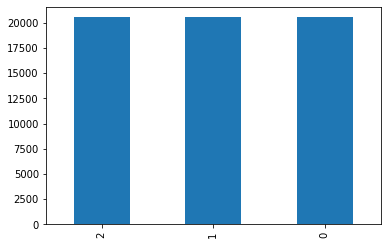

In [ ]:
# observe that data has been balanced
pd.Series(os_train_y).value_counts().plot.bar()
plt.show()

In [ ]:
os_train_X = pd.DataFrame(data=os_train_X, columns = X_train_final.columns)
os_train_y= pd.DataFrame(data=os_train_y)

In [ ]:
print(os_train_y.shape)
print(os_train_X.shape)

(61629, 1)
(61629, 1226)


## **7. GBM with SMOTe**

In [ ]:
clf_GBM_smot = GradientBoostingClassifier(n_estimators=50,
                                       learning_rate=0.01,
                                       subsample=0.8, random_state=123)

In [ ]:
%time clf_GBM_smot.fit(os_train_X, os_train_y)

CPU times: user 11min 12s, sys: 708 ms, total: 11min 13s
Wall time: 11min 9s


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
# Predict
y_pred_train = clf_GBM_smot.predict(os_train_X)
y_pred_test = clf_GBM_smot.predict(X_test_final)

#### **Evaluating the model performance**

In [ ]:
# Model Score
scores = get_metrics(os_train_y, y_pred_train, y_test, y_pred_val, "GBM_SMOTe", scores)
scores


               CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.8132    0.4808    0.6043     20543
           1     0.5752    0.5685    0.5718     20543
           2     0.6061    0.8609    0.7114     20543

    accuracy                         0.6367     61629
   macro avg     0.6648    0.6367    0.6292     61629
weighted avg     0.6648    0.6367    0.6292     61629


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.8116    0.8931    0.8504      8804
           1     0.7085    0.5525    0.6209      3844
           2     0.7089    0.6957    0.7022      2044

    accuracy                         0.7765     14692
   macro avg     0.7430    0.7138    0.7245     14692
weighted avg     0.7703    0.7765    0.7697     14692


   Confusion Matrix FOR TRAIN DATA
            
[[ 9877  5824  4842]
 [ 2211 11678  6654]
 [   58  2799 17686]

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.800006,0.762244,0.756251,0.757859,0.784032,0.742784,0.737329,0.738921
1,DecisionTree,0.948105,0.919313,0.956201,0.936354,0.850054,0.811758,0.829972,0.820330
2,KNN,0.839736,0.784919,0.828441,0.804126,0.759053,0.689427,0.726330,0.705429
3,NaiveBayes,0.589685,0.702588,0.616289,0.580830,0.585693,0.697273,0.611644,0.576811
4,SVM(Linear),0.803244,0.769588,0.760874,0.763707,0.784985,0.746289,0.739303,0.741664
5,RandomForest,0.948105,0.934138,0.940410,0.937231,0.812823,0.770586,0.776374,0.773200
6,GradientBoosting,0.769902,0.687418,0.753400,0.711650,0.758848,0.674333,0.736685,0.696777
7,LGBMClassifier,0.938829,0.925353,0.930015,0.927653,0.847332,0.817299,0.820259,0.818756
8,Adaboost,0.941309,0.951443,0.913721,0.930754,0.806766,0.777492,0.765285,0.771108
9,XGBoost,0.792947,0.731147,0.764592,0.743822,0.806766,0.777492,0.765285,0.771108


## **8. XGBoost with Grid Search CV**

In [ ]:
# Create a XGBoost classifier object
clf_XGB_grid = XGBClassifier()

In [ ]:
# Use a grid over parameters of interest
param_grid = {
     'colsample_bytree': np.linspace(0.6, 0.8, 2),
     'n_estimators':[50, 100],
     'max_depth': [3, 4],
     'gamma': [0.2,0.3,0.4],
     'learning_rate': [0.001, 0.01, 0.1, 1],
     'scale_pos_weight':[4]
}

In [ ]:
# GridSearchCV
CV_XGB_grid = GridSearchCV(estimator=clf_XGB_grid, param_grid=param_grid, n_jobs=-1, scoring='f1_macro')

In [ ]:
# Train the classifier
%time CV_XGB_grid.fit(X_train_final, y_train)

[15:47:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:47:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 4h 59min 14s


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [ ]:
# Find best model
best_xgb_model = CV_XGB_grid.best_estimator_
print(CV_XGB_grid.best_score_, CV_XGB_grid.best_params_)

0.7728899437805399 {'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 1, 'max_depth': 4, 'n_estimators': 100, 'scale_pos_weight': 4}


In [ ]:
# Predict
y_pred_train=best_xgb_model.predict(X_train_final)
y_pred_test=best_xgb_model.predict(X_test_final)

#### **Evaluating the model performance**

In [ ]:
# Model score
scores = get_metrics(y_train, y_pred_train, y_test, y_pred_test, "XGBoost_BestParameters", scores)
scores


               CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.8700    0.9068    0.8880     20543
           1     0.7752    0.6878    0.7289      8968
           2     0.7811    0.8042    0.7925      4770

    accuracy                         0.8352     34281
   macro avg     0.8088    0.7996    0.8031     34281
weighted avg     0.8328    0.8352    0.8331     34281


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

           0     0.8544    0.8921    0.8729      8804
           1     0.7367    0.6537    0.6928      3844
           2     0.7539    0.7705    0.7622      2044

    accuracy                         0.8128     14692
   macro avg     0.7817    0.7721    0.7759     14692
weighted avg     0.8097    0.8128    0.8103     14692


   Confusion Matrix FOR TRAIN DATA
            
[[18629  1371   543]
 [ 2268  6168   532]
 [  516   418  3836]

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,XGBoost_BestParameters,0.835244,0.7996,0.808752,0.803123,0.812823,0.77213,0.781707,0.775927


# **Decision Time!!**

## **From the basic model building and HyperParameter tuning using GridSearch, Decision Tree gave us the better Outcome for the given Data Set.**